In [97]:
pwd

'/imaging/students/Abhi/project'

In [98]:
test_path = 'Balanced Dataset/test'
train_path = 'Balanced Dataset/train'
val_path = 'Balanced Dataset/val'

In [99]:
import os
import pandas as pd
# Function to gather image paths and labels
def gather_image_paths_and_labels(folder_path):
    data = []
    for label in ['Normal', 'pnemo', 'tb']:
        label_folder = os.path.join(folder_path, label)
        for img_file in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_file)
            data.append([img_path, label])
    return data

# Gathering data from train, test, and validation sets
train_data = gather_image_paths_and_labels(train_path)
test_data = gather_image_paths_and_labels(test_path)
val_data = gather_image_paths_and_labels(val_path)

# Creating dataframes for each set
train_df = pd.DataFrame(train_data, columns=['image_path', 'label'])
test_df = pd.DataFrame(test_data, columns=['image_path', 'label'])
val_df = pd.DataFrame(val_data, columns=['image_path', 'label'])

# Combine all data into a single dataframe
full_df = pd.concat([train_df, test_df, val_df], ignore_index=True)


In [100]:
# Count the number of occurrences of 'COVID' and 'Normal' in the 'label' column
label_counts = full_df['label'].value_counts()
print(label_counts)

label
Normal    10206
pnemo      5775
tb         1489
Name: count, dtype: int64


In [101]:
full_df

,image_path,label
0,Balanced Dataset/train/Normal/Normal-2226.png,Normal
1,Balanced Dataset/train/Normal/Normal-2581.png,Normal
2,Balanced Dataset/train/Normal/Normal-3466.png,Normal
3,Balanced Dataset/train/Normal/b064fcb9-571e-49...,Normal
4,Balanced Dataset/train/Normal/CHNCXR_0138_0.png,Normal
...,...,...
17465,Balanced Dataset/val/tb/341ab.png,tb
17466,Balanced Dataset/val/tb/Tuberculosis-676.png,tb
17467,Balanced Dataset/val/tb/Tuberculosis-333.png,tb
17468,Balanced Dataset/val/tb/166ab.png,tb


In [102]:
import os

# Set environment variables to limit OpenBLAS threading
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
# Set the number of threads for OpenMP (adjust as needed)
os.environ["OMP_NUM_THREADS"] = "4"  # You can adjust this number based on your needs


## MecLIP

In [103]:
!pip install git+https://github.com/RyanWangZf/MedCLIP.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/RyanWangZf/MedCLIP.git to /tmp/pip-req-build-s2ba0ryr
  Running command git clone --filter=blob:none --quiet https://github.com/RyanWangZf/MedCLIP.git /tmp/pip-req-build-s2ba0ryr
  Resolved https://github.com/RyanWangZf/MedCLIP.git to commit 9c3396f20d5d54e4fae241b8cb06ca45848e98c9
  Preparing metadata (setup.py) ... done


/home/asharma/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/asharma/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:399: Futu

load model weight from: ./pretrained/medclip-vit
Fold 1: Train size before SMOTE: 13976, Validation size: 3494
Fold 1: Train size after SMOTE: 24492
Epoch 1/10, Fold 1, Loss: 0.7047
Epoch 2/10, Fold 1, Loss: 0.5654
Epoch 3/10, Fold 1, Loss: 0.5305
Epoch 4/10, Fold 1, Loss: 0.5077
Epoch 5/10, Fold 1, Loss: 0.4903
Epoch 6/10, Fold 1, Loss: 0.4765
Epoch 7/10, Fold 1, Loss: 0.4649
Epoch 8/10, Fold 1, Loss: 0.4554
Epoch 9/10, Fold 1, Loss: 0.4470
Epoch 10/10, Fold 1, Loss: 0.4391

Fold 1:
Accuracy: 0.7948, Precision: 0.7320, Recall: 0.8077, F1 Score: 0.7570
Confusion Matrix:
[[1526  381  135]
 [  87 1014   54]
 [  44   16  237]]
Fold 2: Train size before SMOTE: 13976, Validation size: 3494
Fold 2: Train size after SMOTE: 24495
Epoch 1/10, Fold 2, Loss: 0.6955
Epoch 2/10, Fold 2, Loss: 0.5707
Epoch 3/10, Fold 2, Loss: 0.5371
Epoch 4/10, Fold 2, Loss: 0.5153
Epoch 5/10, Fold 2, Loss: 0.4978
Epoch 6/10, Fold 2, Loss: 0.4846
Epoch 7/10, Fold 2, Loss: 0.4731
Epoch 8/10, Fold 2, Loss: 0.4638
Epoc

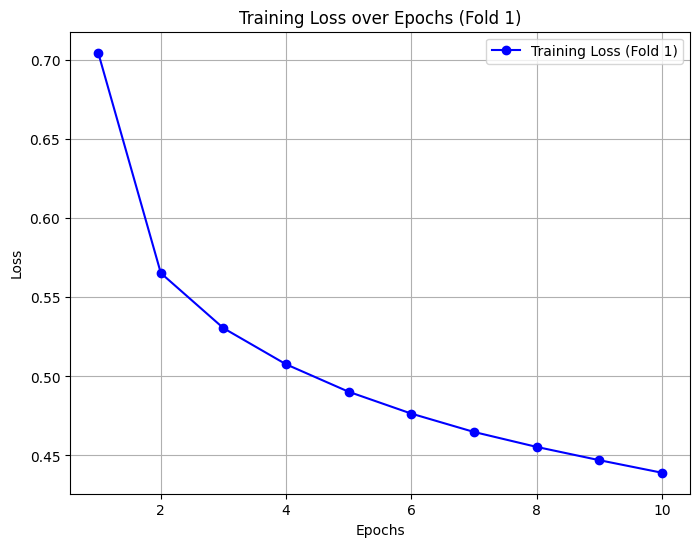

In [104]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from medclip import MedCLIPProcessor, MedCLIPModel, MedCLIPVisionModelViT

# Initialize MedCLIP Processor
processor = MedCLIPProcessor()

# Initialize MedCLIP Model
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained()
model.cuda()

# Map labels to numeric values for multi-class classification
label_mapping = {'Normal': 0, 'pnemo': 1, 'tb': 2}

# Assuming `full_df` is the DataFrame containing all data
# Add numeric label column
full_df['label_numeric'] = full_df['label'].map(label_mapping)

# Function to process images and extract embeddings using MedCLIP's image encoder
def process_images_with_medclip(df):
    embeddings = []
    for idx, row in df.iterrows():
        img_path = row['image_path']
        label = row['label_numeric']

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

        # Preprocess the image using the MedCLIP processor
        inputs = processor(images=image, return_tensors="pt")
        inputs = {k: v.cuda() for k, v in inputs.items()}
        
        with torch.no_grad():
            # Extract image features using MedCLIP's image encoder
            image_features = model.vision_model(**inputs)
            
            # Convert to NumPy array and flatten
            image_embedding = image_features.cpu().numpy().flatten()
            
        embeddings.append([img_path, label, image_embedding])
    return embeddings

# Process images to get embeddings using MedCLIP
embeddings = process_images_with_medclip(full_df)

# Extract embeddings and labels
emb = []
labels = []
for item in embeddings:
    _, label, image_embedding = item
    emb.append(image_embedding)
    labels.append(label)

# Convert embeddings and labels to NumPy arrays
embedding_array = np.array(emb)
labels_array = np.array(labels)

# Define the dataset class using resampled data
class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Long labels for CrossEntropyLoss

        return embedding, label


class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes=3):  # Three output classes for multi-class classification
        super(LinearProbe, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # Three output units

    def forward(self, x):
        return self.fc(x)

# Initialize the necessary variables for 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_number = 1
input_dim = embedding_array.shape[1]

# Initialize a list to store loss values for plotting (for only one fold)
loss_values = []
all_fold_results = []

for train_index, val_index in kf.split(embedding_array, labels_array):
    print(f"Fold {fold_number}: Train size before SMOTE: {len(train_index)}, Validation size: {len(val_index)}")

    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = embedding_array[train_index], embedding_array[val_index]
    y_train_fold, y_val_fold = labels_array[train_index], labels_array[val_index]

    # Apply SMOTE only to the training fold
    smote = SMOTE(random_state=42)
    X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold, y_train_fold)
    
    # Print the new training size after SMOTE
    print(f"Fold {fold_number}: Train size after SMOTE: {len(X_train_fold_resampled)}")

    # Create Dataset and DataLoader for this fold
    train_dataset_fold = EmbeddingsDataset(X_train_fold_resampled, y_train_fold_resampled)
    val_dataset_fold = EmbeddingsDataset(X_val_fold, y_val_fold)

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False)

    # Initialize the linear probe model
    classifier_model = LinearProbe(input_dim).cuda()

    # Initialize the loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
    optimizer = optim.Adam(classifier_model.parameters(), lr=0.0000957)

    # Store loss values for the first fold, but training will happen for all folds
    loss_tracking = (fold_number == 1)

    # Training loop for this fold
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        classifier_model.train()
        running_loss = 0.0
        for embeddings, labels in train_loader_fold:
            embeddings, labels = embeddings.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = classifier_model(embeddings)  # No need to squeeze output for CrossEntropyLoss
            loss = criterion(outputs, labels)  # CrossEntropyLoss expects logits (no sigmoid)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader_fold)
        if loss_tracking:  # Track loss for fold 1 only
            loss_values.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Fold {fold_number}, Loss: {avg_loss:.4f}")

    # Reset collected probabilities and labels for the current fold
    all_probabilities, all_labels = [], []

    # Evaluation for this fold
    classifier_model.eval()
    with torch.no_grad():
        for embeddings, labels in val_loader_fold:
            embeddings = embeddings.cuda()
            outputs = classifier_model(embeddings)
            probabilities = F.softmax(outputs, dim=1).cpu().numpy()  # Get probabilities for all classes

            all_probabilities.extend(probabilities)
            all_labels.extend(labels.numpy())

    # For evaluation, use argmax to get the predicted class with the highest probability
    all_predictions = [np.argmax(probs) for probs in all_probabilities]

    # Calculate evaluation metrics using macro-averaging
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_predictions)

    # Store the fold results
    fold_results = {
        'Fold': fold_number,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': cm
    }
    
    all_fold_results.append(fold_results)
    print(f"\nFold {fold_number}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    fold_number += 1

# Convert all fold results to a DataFrame and display
all_results_df = pd.DataFrame(all_fold_results)
print("\nAll Fold Results:")
print(all_results_df.to_string(index=False))

# Plot the loss values after training (for the first fold only)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', color='b', label='Training Loss (Fold 1)')
plt.title('Training Loss over Epochs (Fold 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [106]:
# Remove the 'Fold' column and the 'Confusion Matrix' column before calculating the averages
average_metrics = all_results_df.drop(columns=['Fold', 'Confusion Matrix']).mean().reset_index()

# Display the average metrics table
print("MedCLIP: Average metrics across five folds:")
print(average_metrics.to_string(index=False))


MedCLIP: Average metrics across five folds:
    index        0
 Accuracy 0.796508
Precision 0.732553
   Recall 0.817909
 F1 Score 0.760871


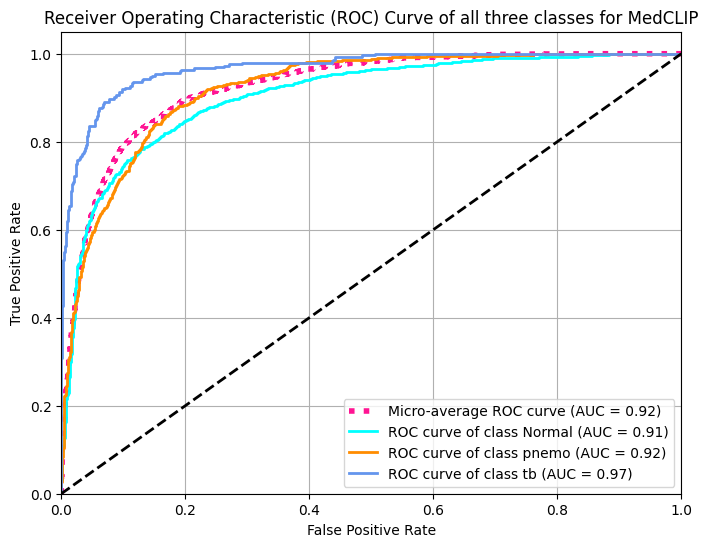

In [108]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_A = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_A = np.array(all_labels)                # Shape: (N_samples,)
         

# Binarize the labels `for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = 3
all_labels_binarized = label_binarize(all_labels_all_folds_A, classes=[0, 1, 2])  # Shape: (N_samples, n_classes)

# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probabilities_all_folds_A[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_A.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
lw = 2

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue']
class_names = ['Normal', 'pnemo', 'tb']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=lw)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of all three classes for MedCLIP')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Micro-average Area Under the Curve (AUC): 0.9241


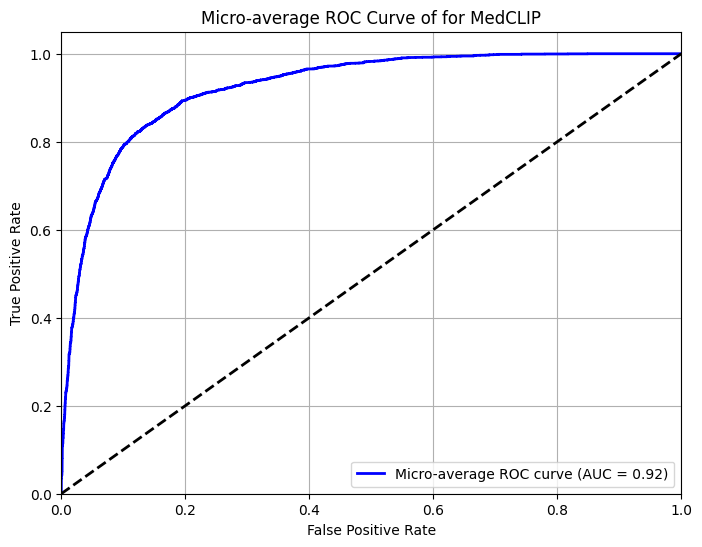

In [109]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_A = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_A = np.array(all_labels)                # Shape: (N_samples,)

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = all_probabilities_all_folds_A.shape[1]
all_labels_binarized = label_binarize(all_labels_all_folds_A, classes=[0, 1, 2])  # Adjust classes as needed

# Compute micro-average ROC curve and ROC area
from sklearn.metrics import roc_curve, auc

# Flatten the arrays for micro-average computation
fpr_micro, tpr_micro, _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_A.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Print the AUC for the micro-average ROC curve
print(f"Micro-average Area Under the Curve (AUC): {roc_auc_micro:.4f}")

# Plot the micro-average ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(fpr_micro, tpr_micro,
         label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})',
         color='blue', linewidth=2)

# Plot the diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve of for MedCLIP')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


/home/asharma/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/asharma/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:399: Futu

load model weight from: ./pretrained/medclip-vit
Fold 1: Train size before SMOTE: 13976, Validation size: 3494
Fold 1: Train size after SMOTE: 24492
Epoch 1/10, Fold 1, Loss: 0.7103
Epoch 2/10, Fold 1, Loss: 0.5670
Epoch 3/10, Fold 1, Loss: 0.5305
Epoch 4/10, Fold 1, Loss: 0.5082
Epoch 5/10, Fold 1, Loss: 0.4905
Epoch 6/10, Fold 1, Loss: 0.4763
Epoch 7/10, Fold 1, Loss: 0.4647
Epoch 8/10, Fold 1, Loss: 0.4559
Epoch 9/10, Fold 1, Loss: 0.4469
Epoch 10/10, Fold 1, Loss: 0.4391

Fold 1 - Threshold = 0.4:
Accuracy: 0.8017, Precision: 0.7366, Recall: 0.8138, F1 Score: 0.7639
Confusion Matrix:
[[1567  335  133]
 [ 111  980   57]
 [  46    8  242]]

Fold 1 - Threshold = 0.5:
Accuracy: 0.8190, Precision: 0.7580, Recall: 0.8376, F1 Score: 0.7869
Confusion Matrix:
[[1530  311  109]
 [  94  958   49]
 [  37    2  236]]

Fold 1 - Threshold = 0.65:
Accuracy: 0.8686, Precision: 0.8239, Recall: 0.9008, F1 Score: 0.8540
Confusion Matrix:
[[1286  203   56]
 [  60  841   26]
 [   8    0  207]]
Fold 2: T

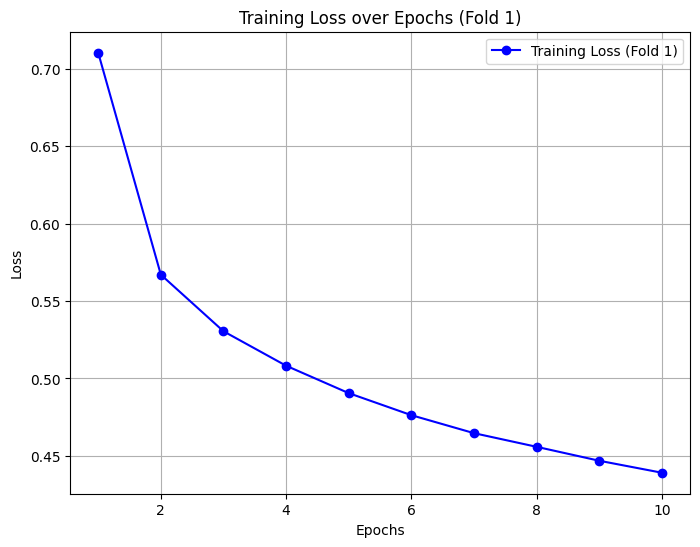

In [88]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from medclip import MedCLIPProcessor, MedCLIPModel, MedCLIPVisionModelViT

# Initialize MedCLIP Processor
processor = MedCLIPProcessor()

# Initialize MedCLIP Model
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained()
model.cuda()

# Map labels to numeric values for multi-class classification
label_mapping = {'Normal': 0, 'pnemo': 1, 'tb': 2}

# Assuming `full_df` is the DataFrame containing all data
# Add numeric label column
full_df['label_numeric'] = full_df['label'].map(label_mapping)

# Function to process images and extract embeddings using MedCLIP's image encoder
def process_images_with_medclip(df):
    embeddings = []
    for idx, row in df.iterrows():
        img_path = row['image_path']
        label = row['label_numeric']

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

        # Preprocess the image using the MedCLIP processor
        inputs = processor(images=image, return_tensors="pt")
        inputs = {k: v.cuda() for k, v in inputs.items()}
        
        with torch.no_grad():
            # Extract image features using MedCLIP's image encoder
            image_features = model.vision_model(**inputs)
            
            # Convert to NumPy array and flatten
            image_embedding = image_features.cpu().numpy().flatten()
            
        embeddings.append([img_path, label, image_embedding])
    return embeddings

# Process images to get embeddings using MedCLIP
embeddings = process_images_with_medclip(full_df)

# Extract embeddings and labels
emb = []
labels = []
for item in embeddings:
    _, label, image_embedding = item
    emb.append(image_embedding)
    labels.append(label)

# Convert embeddings and labels to NumPy arrays
embedding_array = np.array(emb)
labels_array = np.array(labels)

# Define the dataset class using resampled data
class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Long labels for CrossEntropyLoss

        return embedding, label


class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes=3):  # Three output classes for multi-class classification
        super(LinearProbe, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # Three output units

    def forward(self, x):
        return self.fc(x)

# Initialize the necessary variables for 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_number = 1
input_dim = embedding_array.shape[1]

# Initialize a list to store loss values for plotting (for only one fold)
loss_values = []
all_fold_results = []

for train_index, val_index in kf.split(embedding_array, labels_array):
    print(f"Fold {fold_number}: Train size before SMOTE: {len(train_index)}, Validation size: {len(val_index)}")

    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = embedding_array[train_index], embedding_array[val_index]
    y_train_fold, y_val_fold = labels_array[train_index], labels_array[val_index]

    # Apply SMOTE only to the training fold
    smote = SMOTE(random_state=42)
    X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold, y_train_fold)
    
    # Print the new training size after SMOTE
    print(f"Fold {fold_number}: Train size after SMOTE: {len(X_train_fold_resampled)}")

    # Create Dataset and DataLoader for this fold
    train_dataset_fold = EmbeddingsDataset(X_train_fold_resampled, y_train_fold_resampled)
    val_dataset_fold = EmbeddingsDataset(X_val_fold, y_val_fold)

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False)

    # Initialize the linear probe model
    classifier_model = LinearProbe(input_dim).cuda()

    # Initialize the loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
    optimizer = optim.Adam(classifier_model.parameters(), lr=0.0000957)

    # Store loss values for the first fold, but training will happen for all folds
    loss_tracking = (fold_number == 1)

    # Training loop for this fold
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        classifier_model.train()
        running_loss = 0.0
        for embeddings, labels in train_loader_fold:
            embeddings, labels = embeddings.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = classifier_model(embeddings)  # No need to squeeze output for CrossEntropyLoss
            loss = criterion(outputs, labels)  # CrossEntropyLoss expects logits (no sigmoid)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader_fold)
        if loss_tracking:  # Track loss for fold 1 only
            loss_values.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Fold {fold_number}, Loss: {avg_loss:.4f}")

    # Reset collected probabilities and labels for the current fold
    all_probabilities, all_labels = [], []

    # Evaluation for this fold
    classifier_model.eval()
    with torch.no_grad():
        for embeddings, labels in val_loader_fold:
            embeddings = embeddings.cuda()
            outputs = classifier_model(embeddings)
            probabilities = F.softmax(outputs, dim=1).cpu().numpy()  # Get probabilities for all classes

            all_probabilities.extend(probabilities)
            all_labels.extend(labels.numpy())

    # Evaluate at different thresholds for multi-class classification
    fold_results = []
    for threshold in [0.4, 0.5, 0.65]:
        all_predictions = []
        for probs in all_probabilities:
            max_prob = np.max(probs)
            if max_prob >= threshold:
                all_predictions.append(np.argmax(probs))
            else:
                # If no class exceeds the threshold, mark as "uncertain" (-1)
                all_predictions.append(-1)

        # Filter out "uncertain" predictions from the metrics
        valid_predictions = [p for p in all_predictions if p != -1]
        valid_labels = [l for i, l in enumerate(all_labels) if all_predictions[i] != -1]

        if len(valid_predictions) > 0:
            accuracy = accuracy_score(valid_labels, valid_predictions)
            precision = precision_score(valid_labels, valid_predictions, average='macro', zero_division=0)
            recall = recall_score(valid_labels, valid_predictions, average='macro', zero_division=0)
            f1 = f1_score(valid_labels, valid_predictions, average='macro', zero_division=0)

            cm = confusion_matrix(valid_labels, valid_predictions)
        else:
            accuracy = precision = recall = f1 = 0
            cm = np.zeros((3, 3))

        fold_results.append({
            'Fold': fold_number,
            'Threshold': threshold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': cm
        })

        print(f"\nFold {fold_number} - Threshold = {threshold}:")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print(f"Confusion Matrix:\n{cm}")

    # Store the fold results for each threshold
    all_fold_results.extend(fold_results)
    fold_number += 1

# Convert all fold results to a DataFrame and display
all_results_df = pd.DataFrame(all_fold_results)
print("\nAll Fold Results:")
print(all_results_df.to_string(index=False))

# Plot the loss values after training (for the first fold only)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', color='b', label='Training Loss (Fold 1)')
plt.title('Training Loss over Epochs (Fold 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [89]:
# Remove the 'Fold' column before calculating the averages
average_metrics = all_results_df.drop(columns=['Fold']).groupby('Threshold').mean().reset_index()

# Display the average metrics table
print("MedCLIP: Average metrics across five folds for each threshold:")
print(average_metrics.to_string(index=False))


MedCLIP: Average metrics across five folds for each threshold:
 Threshold  Accuracy  Precision   Recall  F1 Score                                                   Confusion Matrix
      0.40  0.794714   0.729303 0.823733  0.759227 [[1543.4, 329.0, 159.2], [121.8, 959.8, 66.8], [28.4, 8.4, 259.4]]
      0.50  0.809591   0.747409 0.840068  0.778315 [[1500.0, 305.2, 135.6], [106.4, 937.0, 55.8], [24.8, 4.8, 253.0]]
      0.65  0.861620   0.814869 0.893987  0.844580    [[1235.0, 201.0, 65.4], [56.8, 824.0, 32.6], [8.0, 1.6, 218.8]]


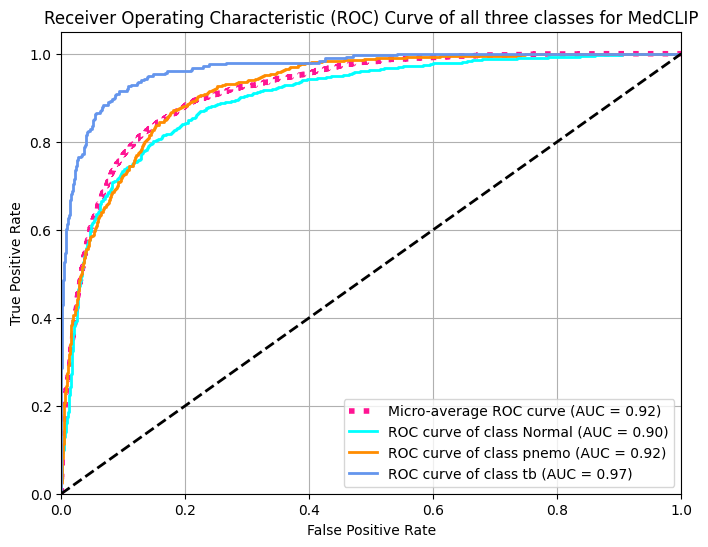

In [90]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_A = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_A = np.array(all_labels)                # Shape: (N_samples,)
         

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = 3
all_labels_binarized = label_binarize(all_labels_all_folds_A, classes=[0, 1, 2])  # Shape: (N_samples, n_classes)

# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probabilities_all_folds_A[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_A.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
lw = 2

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue']
class_names = ['Normal', 'pnemo', 'tb']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=lw)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of all three classes for MedCLIP')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Micro-average Area Under the Curve (AUC): 0.9188


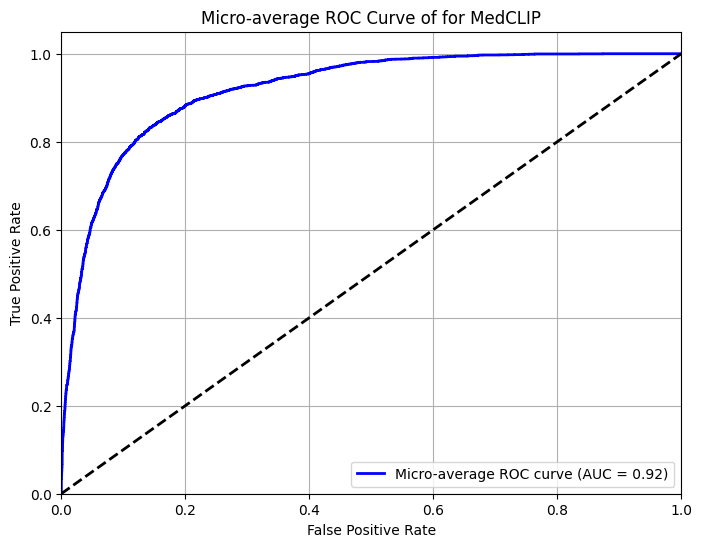

In [91]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_A = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_A = np.array(all_labels)                # Shape: (N_samples,)

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = all_probabilities_all_folds_A.shape[1]
all_labels_binarized = label_binarize(all_labels_all_folds_A, classes=[0, 1, 2])  # Adjust classes as needed

# Compute micro-average ROC curve and ROC area
from sklearn.metrics import roc_curve, auc

# Flatten the arrays for micro-average computation
fpr_micro, tpr_micro, _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_A.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Print the AUC for the micro-average ROC curve
print(f"Micro-average Area Under the Curve (AUC): {roc_auc_micro:.4f}")

# Plot the micro-average ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(fpr_micro, tpr_micro,
         label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})',
         color='blue', linewidth=2)

# Plot the diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve of for MedCLIP')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Hybrid

/home/asharma/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/asharma/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/

load model weight from: ./pretrained/medclip-vit
Fold 1: Train size before SMOTE: 13976, Validation size: 3494
Fold 1: Train size after SMOTE: 24492
Epoch 1/10, Fold 1, Loss: 0.5750
Epoch 2/10, Fold 1, Loss: 0.4776
Epoch 3/10, Fold 1, Loss: 0.4404
Epoch 4/10, Fold 1, Loss: 0.4205
Epoch 5/10, Fold 1, Loss: 0.4030
Epoch 6/10, Fold 1, Loss: 0.3929
Epoch 7/10, Fold 1, Loss: 0.3848
Epoch 8/10, Fold 1, Loss: 0.3779
Epoch 9/10, Fold 1, Loss: 0.3691
Epoch 10/10, Fold 1, Loss: 0.3674

Fold 1:
Accuracy: 0.8214, Precision: 0.7769, Recall: 0.8499, F1 Score: 0.8046
Confusion Matrix:
[[1603  341   98]
 [ 123 1000   32]
 [  18   12  267]]
Fold 2: Train size before SMOTE: 13976, Validation size: 3494
Fold 2: Train size after SMOTE: 24495
Epoch 1/10, Fold 2, Loss: 0.5821
Epoch 2/10, Fold 2, Loss: 0.4853
Epoch 3/10, Fold 2, Loss: 0.4491
Epoch 4/10, Fold 2, Loss: 0.4288
Epoch 5/10, Fold 2, Loss: 0.4149
Epoch 6/10, Fold 2, Loss: 0.4022
Epoch 7/10, Fold 2, Loss: 0.3932
Epoch 8/10, Fold 2, Loss: 0.3881
Epoc

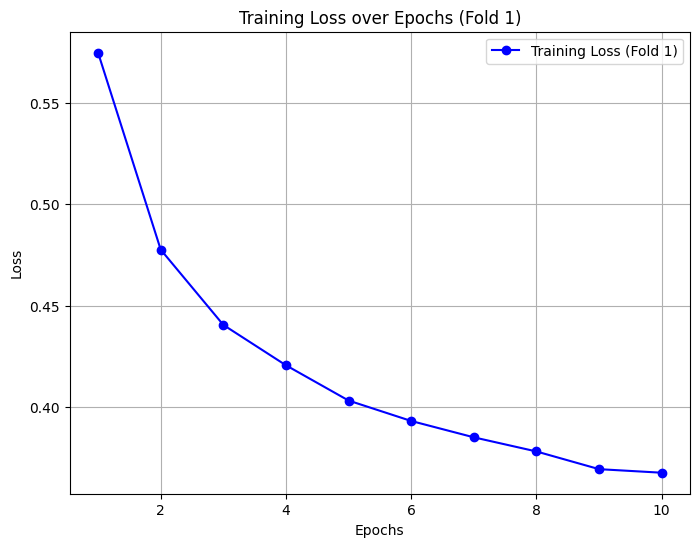

In [127]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from medclip import MedCLIPProcessor, MedCLIPModel, MedCLIPVisionModelViT

# Initialize MedCLIP Processor
processor = MedCLIPProcessor()

# Initialize MedCLIP Model
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained()
model.cuda()

# Map labels to numeric values for multi-class classification
label_mapping = {'Normal': 0, 'pnemo': 1, 'tb': 2}

# Assuming `full_df` is the DataFrame containing all data
# Add numeric label column
full_df['label_numeric'] = full_df['label'].map(label_mapping)

# Function to process images and extract embeddings using MedCLIP's image encoder
def process_images_with_medclip(df):
    embeddings = []
    for idx, row in df.iterrows():
        img_path = row['image_path']
        label = row['label_numeric']

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

        # Preprocess the image using the MedCLIP processor
        inputs = processor(images=image, return_tensors="pt")
        inputs = {k: v.cuda() for k, v in inputs.items()}
        
        with torch.no_grad():
            # Extract image features using MedCLIP's image encoder
            image_features = model.vision_model(**inputs)
            
            # Convert to NumPy array and flatten
            image_embedding = image_features.cpu().numpy().flatten()
            
        embeddings.append([img_path, label, image_embedding])
    return embeddings

# Process images to get embeddings using MedCLIP
embeddings = process_images_with_medclip(full_df)

# Extract embeddings and labels
emb = []
labels = []
for item in embeddings:
    _, label, image_embedding = item
    emb.append(image_embedding)
    labels.append(label)

# Convert embeddings and labels to NumPy arrays
embedding_array = np.array(emb)
labels_array = np.array(labels)

# Define the dataset class using resampled data
class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Long labels for CrossEntropyLoss

        return embedding, label


class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes=3):  # Three output classes for multi-class classification
        super(LinearProbe, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # Three output units

    def forward(self, x):
        return self.fc(x)

# Initialize the necessary variables for 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_number = 1
input_dim = embedding_array.shape[1]

# Initialize a list to store loss values for plotting (for only one fold)
loss_values = []
all_fold_results = []

for train_index, val_index in kf.split(embedding_array, labels_array):
    print(f"Fold {fold_number}: Train size before SMOTE: {len(train_index)}, Validation size: {len(val_index)}")

    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = embedding_array[train_index], embedding_array[val_index]
    y_train_fold, y_val_fold = labels_array[train_index], labels_array[val_index]

    # Apply SMOTE only to the training fold
    smote = SMOTE(random_state=42)
    X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold, y_train_fold)
    
    # Print the new training size after SMOTE
    print(f"Fold {fold_number}: Train size after SMOTE: {len(X_train_fold_resampled)}")

    # Create Dataset and DataLoader for this fold
    train_dataset_fold = EmbeddingsDataset(X_train_fold_resampled, y_train_fold_resampled)
    val_dataset_fold = EmbeddingsDataset(X_val_fold, y_val_fold)

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False)

    # Initialize the linear probe model
    classifier_model = LinearProbe(input_dim).cuda()

    # Initialize the loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
    optimizer = optim.Adam(classifier_model.parameters(), lr=0.00045)

    # Store loss values for the first fold, but training will happen for all folds
    loss_tracking = (fold_number == 1)

    # Training loop for this fold
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        classifier_model.train()
        running_loss = 0.0
        for embeddings, labels in train_loader_fold:
            embeddings, labels = embeddings.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = classifier_model(embeddings)  # No need to squeeze output for CrossEntropyLoss
            loss = criterion(outputs, labels)  # CrossEntropyLoss expects logits (no sigmoid)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader_fold)
        if loss_tracking:  # Track loss for fold 1 only
            loss_values.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Fold {fold_number}, Loss: {avg_loss:.4f}")

    # Reset collected probabilities and labels for the current fold
    all_probabilities, all_labels = [], []

    # Evaluation for this fold
    classifier_model.eval()
    with torch.no_grad():
        for embeddings, labels in val_loader_fold:
            embeddings = embeddings.cuda()
            outputs = classifier_model(embeddings)
            probabilities = F.softmax(outputs, dim=1).cpu().numpy()  # Get probabilities for all classes

            all_probabilities.extend(probabilities)
            all_labels.extend(labels.numpy())

    # For evaluation, use argmax to get the predicted class with the highest probability
    all_predictions = [np.argmax(probs) for probs in all_probabilities]

    # Calculate evaluation metrics using macro-averaging
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_predictions)

    # Store the fold results
    fold_results = {
        'Fold': fold_number,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': cm
    }
    
    all_fold_results.append(fold_results)
    print(f"\nFold {fold_number}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    fold_number += 1

# Convert all fold results to a DataFrame and display
all_results_df = pd.DataFrame(all_fold_results)
print("\nAll Fold Results:")
print(all_results_df.to_string(index=False))

# Plot the loss values after training (for the first fold only)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', color='b', label='Training Loss (Fold 1)')
plt.title('Training Loss over Epochs (Fold 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [128]:
# Remove the 'Fold' column and the 'Confusion Matrix' column before calculating the averages
average_metrics = all_results_df.drop(columns=['Fold', 'Confusion Matrix']).mean().reset_index()

# Display the average metrics table
print("Hybrid: Average metrics across five folds:")
print(average_metrics.to_string(index=False))


Hybrid: Average metrics across five folds:
    index        0
 Accuracy 0.812994
Precision 0.765396
   Recall 0.839449
 F1 Score 0.791403


In [ ]:
BioVIL: Average metrics across five folds:
    index        0
 Accuracy 0.752261
Precision 0.724556
   Recall 0.806475
 F1 Score 0.754669

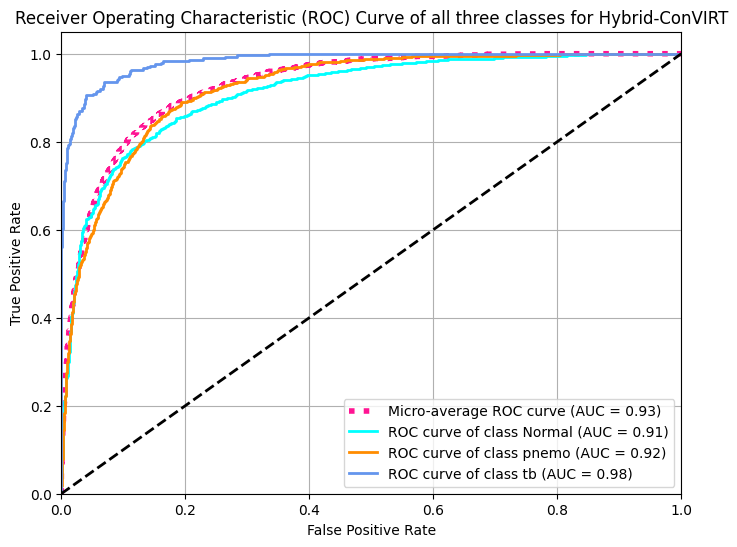

In [129]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_B = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_B = np.array(all_labels)                # Shape: (N_samples,)

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = 3
all_labels_binarized = label_binarize(all_labels_all_folds_B, classes=[0, 1, 2])  # Shape: (N_samples, n_classes)

# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probabilities_all_folds_B[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_B.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
lw = 2

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue']
class_names = ['Normal', 'pnemo', 'tb']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=lw)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of all three classes for Hybrid-ConVIRT')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Micro-average Area Under the Curve (AUC): 0.9297


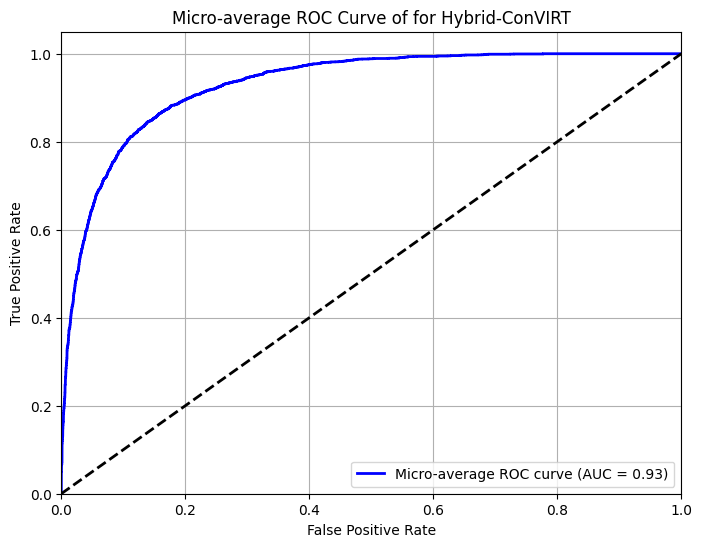

In [130]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_B = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_B = np.array(all_labels)                # Shape: (N_samples,)

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = all_probabilities_all_folds_B.shape[1]
all_labels_binarized = label_binarize(all_labels_all_folds_B, classes=[0, 1, 2])  # Adjust classes as needed

# Compute micro-average ROC curve and ROC area
from sklearn.metrics import roc_curve, auc

# Flatten the arrays for micro-average computation
fpr_micro, tpr_micro, _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_B.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Print the AUC for the micro-average ROC curve
print(f"Micro-average Area Under the Curve (AUC): {roc_auc_micro:.4f}")

# Plot the micro-average ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(fpr_micro, tpr_micro,
         label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})',
         color='blue', linewidth=2)

# Plot the diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve of for Hybrid-ConVIRT')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## HyBRID withthresholdwhich is wrong

/home/asharma/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/asharma/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:399: Futu

load model weight from: ./pretrained/medclip-vit
Fold 1: Train size before SMOTE: 13976, Validation size: 3494
Fold 1: Train size after SMOTE: 24492
Epoch 1/10, Fold 1, Loss: 0.6004
Epoch 2/10, Fold 1, Loss: 0.4982
Epoch 3/10, Fold 1, Loss: 0.4632
Epoch 4/10, Fold 1, Loss: 0.4412
Epoch 5/10, Fold 1, Loss: 0.4238
Epoch 6/10, Fold 1, Loss: 0.4119
Epoch 7/10, Fold 1, Loss: 0.4030
Epoch 8/10, Fold 1, Loss: 0.3934
Epoch 9/10, Fold 1, Loss: 0.3875
Epoch 10/10, Fold 1, Loss: 0.3819

Fold 1 - Threshold = 0.4:
Accuracy: 0.7944, Precision: 0.7412, Recall: 0.8448, F1 Score: 0.7714
Confusion Matrix:
[[1468  402  164]
 [  87 1021   39]
 [   9   14  274]]

Fold 1 - Threshold = 0.5:
Accuracy: 0.8080, Precision: 0.7582, Recall: 0.8604, F1 Score: 0.7893
Confusion Matrix:
[[1441  380  143]
 [  77 1013   31]
 [   7    9  269]]

Fold 1 - Threshold = 0.65:
Accuracy: 0.8520, Precision: 0.8204, Recall: 0.8979, F1 Score: 0.8468
Confusion Matrix:
[[1193  271   76]
 [  44  941   17]
 [   3    2  244]]
Fold 2: T

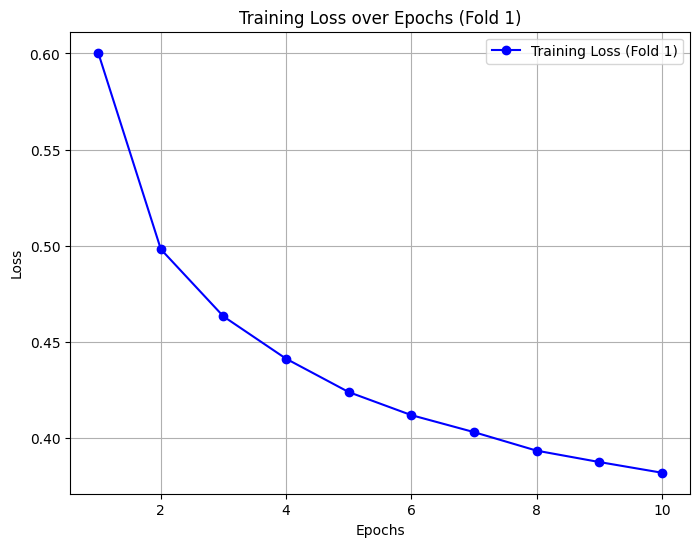

In [92]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from medclip import MedCLIPProcessor, MedCLIPModel, MedCLIPVisionModelViT

# Initialize MedCLIP Processor
processor = MedCLIPProcessor()

# Initialize MedCLIP Model
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained()
model.cuda()

# Map labels to numeric values for multi-class classification
label_mapping = {'Normal': 0, 'pnemo': 1, 'tb': 2}

# Assuming `full_df` is the DataFrame containing all data
# Add numeric label column
full_df['label_numeric'] = full_df['label'].map(label_mapping)

# Function to process images and extract embeddings using MedCLIP's image encoder
def process_images_with_medclip(df):
    embeddings = []
    for idx, row in df.iterrows():
        img_path = row['image_path']
        label = row['label_numeric']

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

        # Preprocess the image using the MedCLIP processor
        inputs = processor(images=image, return_tensors="pt")
        inputs = {k: v.cuda() for k, v in inputs.items()}
        
        with torch.no_grad():
            # Extract image features using MedCLIP's image encoder
            image_features = model.vision_model(**inputs)
            
            # Convert to NumPy array and flatten
            image_embedding = image_features.cpu().numpy().flatten()
            
        embeddings.append([img_path, label, image_embedding])
    return embeddings

# Process images to get embeddings using MedCLIP
embeddings = process_images_with_medclip(full_df)

# Extract embeddings and labels
emb = []
labels = []
for item in embeddings:
    _, label, image_embedding = item
    emb.append(image_embedding)
    labels.append(label)

# Convert embeddings and labels to NumPy arrays
embedding_array = np.array(emb)
labels_array = np.array(labels)

# Define the dataset class using resampled data
class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Long labels for CrossEntropyLoss

        return embedding, label


class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes=3):  # Three output classes for multi-class classification
        super(LinearProbe, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # Three output units

    def forward(self, x):
        return self.fc(x)

# Initialize the necessary variables for 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_number = 1
input_dim = embedding_array.shape[1]

# Initialize a list to store loss values for plotting (for only one fold)
loss_values = []
all_fold_results = []

for train_index, val_index in kf.split(embedding_array, labels_array):
    print(f"Fold {fold_number}: Train size before SMOTE: {len(train_index)}, Validation size: {len(val_index)}")

    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = embedding_array[train_index], embedding_array[val_index]
    y_train_fold, y_val_fold = labels_array[train_index], labels_array[val_index]

    # Apply SMOTE only to the training fold
    smote = SMOTE(random_state=42)
    X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold, y_train_fold)
    
    # Print the new training size after SMOTE
    print(f"Fold {fold_number}: Train size after SMOTE: {len(X_train_fold_resampled)}")

    # Create Dataset and DataLoader for this fold
    train_dataset_fold = EmbeddingsDataset(X_train_fold_resampled, y_train_fold_resampled)
    val_dataset_fold = EmbeddingsDataset(X_val_fold, y_val_fold)

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False)

    # Initialize the linear probe model
    classifier_model = LinearProbe(input_dim).cuda()

    # Initialize the loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
    optimizer = optim.Adam(classifier_model.parameters(), lr=0.0003)

    # Store loss values for the first fold, but training will happen for all folds
    loss_tracking = (fold_number == 1)

    # Training loop for this fold
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        classifier_model.train()
        running_loss = 0.0
        for embeddings, labels in train_loader_fold:
            embeddings, labels = embeddings.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = classifier_model(embeddings)  # No need to squeeze output for CrossEntropyLoss
            loss = criterion(outputs, labels)  # CrossEntropyLoss expects logits (no sigmoid)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader_fold)
        if loss_tracking:  # Track loss for fold 1 only
            loss_values.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Fold {fold_number}, Loss: {avg_loss:.4f}")

    # Reset collected probabilities and labels for the current fold
    all_probabilities, all_labels = [], []

    # Evaluation for this fold
    classifier_model.eval()
    with torch.no_grad():
        for embeddings, labels in val_loader_fold:
            embeddings = embeddings.cuda()
            outputs = classifier_model(embeddings)
            probabilities = F.softmax(outputs, dim=1).cpu().numpy()  # Get probabilities for all classes

            all_probabilities.extend(probabilities)
            all_labels.extend(labels.numpy())

    # Evaluate at different thresholds for multi-class classification
    fold_results = []
    for threshold in [0.4, 0.5, 0.65]:
        all_predictions = []
        for probs in all_probabilities:
            max_prob = np.max(probs)
            if max_prob >= threshold:
                all_predictions.append(np.argmax(probs))
            else:
                # If no class exceeds the threshold, mark as "uncertain" (-1)
                all_predictions.append(-1)

        # Filter out "uncertain" predictions from the metrics
        valid_predictions = [p for p in all_predictions if p != -1]
        valid_labels = [l for i, l in enumerate(all_labels) if all_predictions[i] != -1]

        if len(valid_predictions) > 0:
            accuracy = accuracy_score(valid_labels, valid_predictions)
            precision = precision_score(valid_labels, valid_predictions, average='macro', zero_division=0)
            recall = recall_score(valid_labels, valid_predictions, average='macro', zero_division=0)
            f1 = f1_score(valid_labels, valid_predictions, average='macro', zero_division=0)

            cm = confusion_matrix(valid_labels, valid_predictions)
        else:
            accuracy = precision = recall = f1 = 0
            cm = np.zeros((3, 3))

        fold_results.append({
            'Fold': fold_number,
            'Threshold': threshold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': cm
        })

        print(f"\nFold {fold_number} - Threshold = {threshold}:")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print(f"Confusion Matrix:\n{cm}")

    # Store the fold results for each threshold
    all_fold_results.extend(fold_results)
    fold_number += 1

# Convert all fold results to a DataFrame and display
all_results_df = pd.DataFrame(all_fold_results)
print("\nAll Fold Results:")
print(all_results_df.to_string(index=False))

# Plot the loss values after training (for the first fold only)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', color='b', label='Training Loss (Fold 1)')
plt.title('Training Loss over Epochs (Fold 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [93]:
# Remove the 'Fold' column before calculating the averages
average_metrics = all_results_df.drop(columns=['Fold']).groupby('Threshold').mean().reset_index()

# Display the average metrics table
print("Hybrid-ConVIRT: Average metrics across five folds for each threshold:")
print(average_metrics.to_string(index=False))


Hybrid-ConVIRT: Average metrics across five folds for each threshold:
 Threshold  Accuracy  Precision   Recall  F1 Score                                                   Confusion Matrix
      0.40  0.805674   0.750085 0.843973  0.780889 [[1551.4, 341.4, 140.2], [120.8, 980.0, 49.0], [16.2, 8.6, 272.2]]
      0.50  0.817346   0.765980 0.856380  0.796703 [[1519.0, 323.0, 122.8], [108.6, 964.6, 40.4], [14.8, 5.4, 268.6]]
      0.65  0.865902   0.830777 0.898571  0.856395    [[1304.4, 217.2, 64.8], [59.2, 861.0, 22.8], [8.0, 1.8, 247.2]]


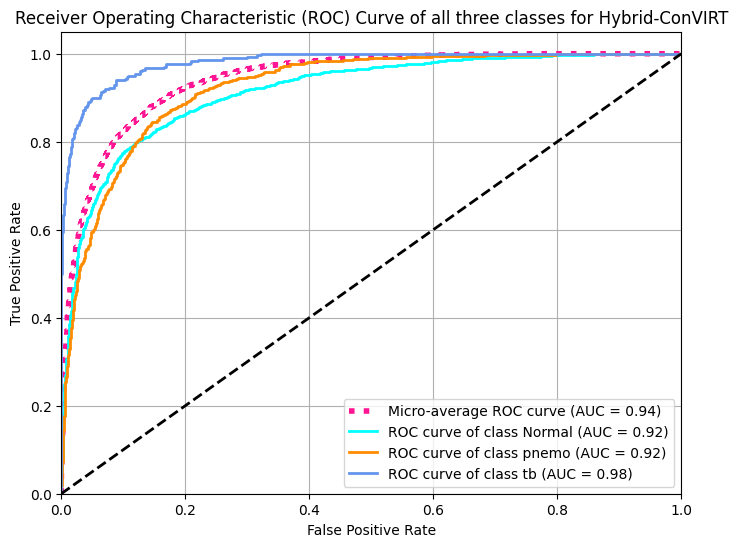

In [94]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_B = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_B = np.array(all_labels)                # Shape: (N_samples,)

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = 3
all_labels_binarized = label_binarize(all_labels_all_folds_B, classes=[0, 1, 2])  # Shape: (N_samples, n_classes)

# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probabilities_all_folds_B[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_B.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
lw = 2

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue']
class_names = ['Normal', 'pnemo', 'tb']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=lw)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of all three classes for Hybrid-ConVIRT')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Micro-average Area Under the Curve (AUC): 0.9424


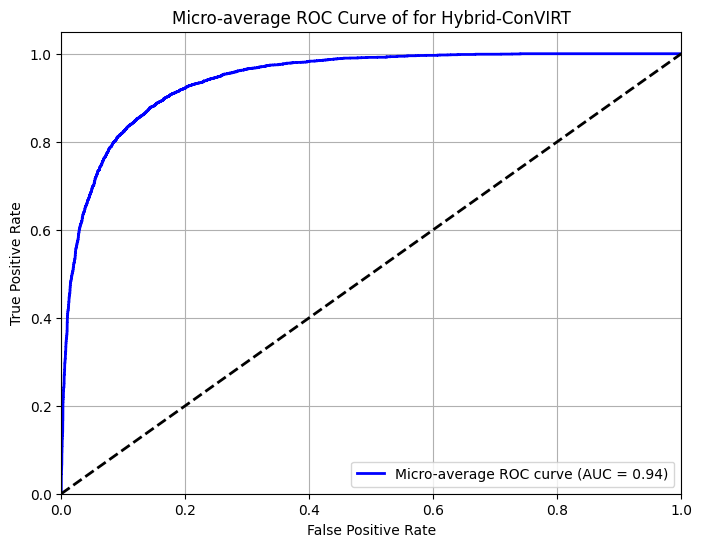

In [95]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_B = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_B = np.array(all_labels)                # Shape: (N_samples,)

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = all_probabilities_all_folds_B.shape[1]
all_labels_binarized = label_binarize(all_labels_all_folds_B, classes=[0, 1, 2])  # Adjust classes as needed

# Compute micro-average ROC curve and ROC area
from sklearn.metrics import roc_curve, auc

# Flatten the arrays for micro-average computation
fpr_micro, tpr_micro, _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_B.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Print the AUC for the micro-average ROC curve
print(f"Micro-average Area Under the Curve (AUC): {roc_auc_micro:.4f}")

# Plot the micro-average ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(fpr_micro, tpr_micro,
         label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})',
         color='blue', linewidth=2)

# Plot the diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve of for Hybrid-ConVIRT')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## CLIP (Biovil)

/home/asharma/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/asharma/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user

Fold 1: Train size before SMOTE: 13976, Validation size: 3494
Fold 1: Train size after SMOTE: 24492
Epoch 1/10, Fold 1, Loss: 0.9435
Epoch 2/10, Fold 1, Loss: 0.7792
Epoch 3/10, Fold 1, Loss: 0.6912
Epoch 4/10, Fold 1, Loss: 0.6341
Epoch 5/10, Fold 1, Loss: 0.5936
Epoch 6/10, Fold 1, Loss: 0.5636
Epoch 7/10, Fold 1, Loss: 0.5405
Epoch 8/10, Fold 1, Loss: 0.5219
Epoch 9/10, Fold 1, Loss: 0.5072
Epoch 10/10, Fold 1, Loss: 0.4947

Fold 1:
Accuracy: 0.7553, Precision: 0.7329, Recall: 0.8122, F1 Score: 0.7618
Confusion Matrix:
[[1445  482  115]
 [ 229  916   10]
 [  14    5  278]]
Fold 2: Train size before SMOTE: 13976, Validation size: 3494
Fold 2: Train size after SMOTE: 24495
Epoch 1/10, Fold 2, Loss: 0.9614
Epoch 2/10, Fold 2, Loss: 0.7890
Epoch 3/10, Fold 2, Loss: 0.6969
Epoch 4/10, Fold 2, Loss: 0.6372
Epoch 5/10, Fold 2, Loss: 0.5957
Epoch 6/10, Fold 2, Loss: 0.5650
Epoch 7/10, Fold 2, Loss: 0.5413
Epoch 8/10, Fold 2, Loss: 0.5227
Epoch 9/10, Fold 2, Loss: 0.5078
Epoch 10/10, Fold 2,

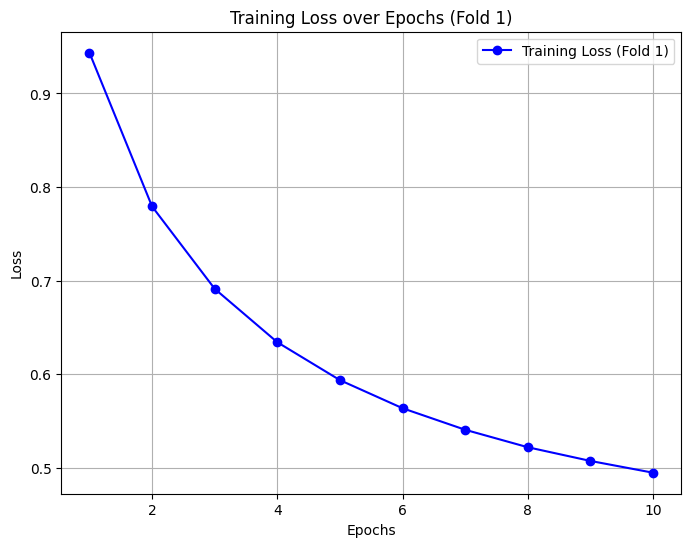

In [139]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from transformers import CLIPProcessor, CLIPModel

# Initialize the CLIP Processor and Model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.cuda()

# Map labels to numeric values for multi-class classification
label_mapping = {'Normal': 0, 'pnemo': 1, 'tb': 2}

# Assuming `full_df` is the DataFrame containing all data
# Add numeric label column
full_df['label_numeric'] = full_df['label'].map(label_mapping)

# Function to process images and extract embeddings using CLIP's image encoder
def process_images_with_clip(df):
    embeddings = []
    for idx, row in df.iterrows():
        img_path = row['image_path']
        label = row['label_numeric']

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

        # Preprocess the image using the CLIP processor
        inputs = clip_processor(images=image, return_tensors="pt")
        inputs = {k: v.cuda() for k, v in inputs.items()}
        
        with torch.no_grad():
            # Extract image features using CLIP's image encoder
            image_features = clip_model.get_image_features(**inputs)
            
            # Convert to NumPy array and flatten
            image_embedding = image_features.cpu().numpy().flatten()
            
        embeddings.append([img_path, label, image_embedding])
    return embeddings

# Process images to get embeddings using CLIP
embeddings = process_images_with_clip(full_df)

# Extract embeddings and labels
emb = []
labels = []
for item in embeddings:
    _, label, image_embedding = item
    emb.append(image_embedding)
    labels.append(label)

# Convert embeddings and labels to NumPy arrays
embedding_array = np.array(emb)
labels_array = np.array(labels)

# Define the dataset class using resampled data
class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Long labels for CrossEntropyLoss

        return embedding, label


class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes=3):  # Three output classes for multi-class classification
        super(LinearProbe, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # Three output units

    def forward(self, x):
        return self.fc(x)

# Initialize the necessary variables for 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_number = 1
input_dim = embedding_array.shape[1]

# Initialize a list to store loss values for plotting (for only one fold)
loss_values = []
all_fold_results = []

for train_index, val_index in kf.split(embedding_array, labels_array):
    print(f"Fold {fold_number}: Train size before SMOTE: {len(train_index)}, Validation size: {len(val_index)}")

    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = embedding_array[train_index], embedding_array[val_index]
    y_train_fold, y_val_fold = labels_array[train_index], labels_array[val_index]

    # Apply SMOTE only to the training fold
    smote = SMOTE(random_state=42)
    X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold, y_train_fold)
    
    # Print the new training size after SMOTE
    print(f"Fold {fold_number}: Train size after SMOTE: {len(X_train_fold_resampled)}")

    # Create Dataset and DataLoader for this fold
    train_dataset_fold = EmbeddingsDataset(X_train_fold_resampled, y_train_fold_resampled)
    val_dataset_fold = EmbeddingsDataset(X_val_fold, y_val_fold)

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False)

    # Initialize the linear probe model
    classifier_model = LinearProbe(input_dim).cuda()

    # Initialize the loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
    optimizer = optim.Adam(classifier_model.parameters(), lr=0.0001)

    # Store loss values for the first fold, but training will happen for all folds
    loss_tracking = (fold_number == 1)

    # Training loop for this fold
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        classifier_model.train()
        running_loss = 0.0
        for embeddings, labels in train_loader_fold:
            embeddings, labels = embeddings.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = classifier_model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader_fold)
        if loss_tracking:  # Track loss for fold 1 only
            loss_values.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Fold {fold_number}, Loss: {avg_loss:.4f}")

    # Reset collected probabilities and labels for the current fold
    all_probabilities, all_labels = [], []

    # Evaluation for this fold
    classifier_model.eval()
    with torch.no_grad():
        for embeddings, labels in val_loader_fold:
            embeddings = embeddings.cuda()
            outputs = classifier_model(embeddings)
            probabilities = F.softmax(outputs, dim=1).cpu().numpy()  # Get probabilities for all classes

            all_probabilities.extend(probabilities)
            all_labels.extend(labels.numpy())

    # Evaluate the predictions by using argmax to pick the class with the highest probability
    all_predictions = np.argmax(all_probabilities, axis=1)

    # Calculate evaluation metrics using macro-averaging
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_predictions)

    fold_results = {
        'Fold': fold_number,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': cm
    }

    all_fold_results.append(fold_results)

    print(f"\nFold {fold_number}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    fold_number += 1

# Convert all fold results to a DataFrame and display
all_results_df = pd.DataFrame(all_fold_results)
print("\nAll Fold Results:")
print(all_results_df.to_string(index=False))

# Plot the loss values after training (for the first fold only)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', color='b', label='Training Loss (Fold 1)')
plt.title('Training Loss over Epochs (Fold 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [140]:
# Remove the 'Fold' column and the 'Confusion Matrix' column before calculating the averages
average_metrics = all_results_df.drop(columns=['Fold', 'Confusion Matrix']).mean().reset_index()

# Display the average metrics table
print("BioVIL: Average metrics across five folds:")
print(average_metrics.to_string(index=False))


BioVIL: Average metrics across five folds:
    index        0
 Accuracy 0.752261
Precision 0.724556
   Recall 0.806475
 F1 Score 0.754669


In [ ]:
Hybrid: Average metrics across five folds:
    index        0
 Accuracy 0.812994
Precision 0.765396
   Recall 0.839449
 F1 Score 0.791403

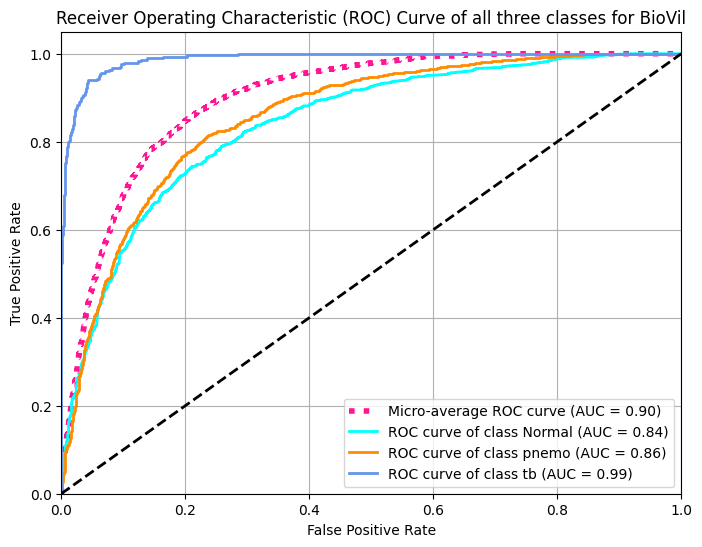

In [142]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_C = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_C = np.array(all_labels)                # Shape: (N_samples,)

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = 3
all_labels_binarized = label_binarize(all_labels_all_folds_C, classes=[0, 1, 2])  # Shape: (N_samples, n_classes)

# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probabilities_all_folds_C[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_C.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
lw = 2

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue']
class_names = ['Normal', 'pnemo', 'tb']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=lw)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of all three classes for BioVil')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Micro-average Area Under the Curve (AUC): 0.8987


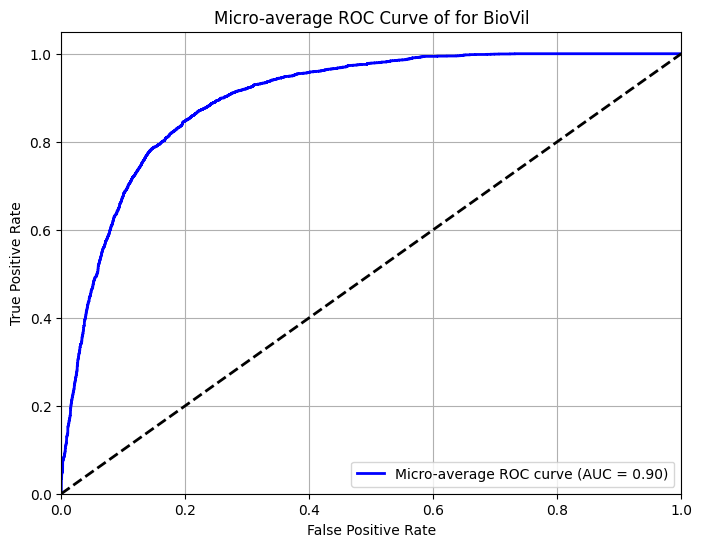

In [143]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_C = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_C = np.array(all_labels)                # Shape: (N_samples,)

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = all_probabilities_all_folds_C.shape[1]
all_labels_binarized = label_binarize(all_labels_all_folds_C, classes=[0, 1, 2])  # Adjust classes as needed

# Compute micro-average ROC curve and ROC area
from sklearn.metrics import roc_curve, auc

# Flatten the arrays for micro-average computation
fpr_micro, tpr_micro, _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_C.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Print the AUC for the micro-average ROC curve
print(f"Micro-average Area Under the Curve (AUC): {roc_auc_micro:.4f}")

# Plot the micro-average ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(fpr_micro, tpr_micro,
         label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})',
         color='blue', linewidth=2)

# Plot the diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve of for BioVil')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## CLIP (biovil) with thresholding which dosent make sense

/home/asharma/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/asharma/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user

Fold 1: Train size before SMOTE: 13976, Validation size: 3494
Fold 1: Train size after SMOTE: 24492
Epoch 1/10, Fold 1, Loss: 0.6455
Epoch 2/10, Fold 1, Loss: 0.4735
Epoch 3/10, Fold 1, Loss: 0.4341
Epoch 4/10, Fold 1, Loss: 0.4143
Epoch 5/10, Fold 1, Loss: 0.4009
Epoch 6/10, Fold 1, Loss: 0.3915
Epoch 7/10, Fold 1, Loss: 0.3844
Epoch 8/10, Fold 1, Loss: 0.3785
Epoch 9/10, Fold 1, Loss: 0.3736
Epoch 10/10, Fold 1, Loss: 0.3690

Fold 1 - Threshold = 0.4:
Accuracy: 0.8003, Precision: 0.7973, Recall: 0.8510, F1 Score: 0.8181
Confusion Matrix:
[[1544  435   62]
 [ 186  966    2]
 [  10    2  284]]

Fold 1 - Threshold = 0.5:
Accuracy: 0.8056, Precision: 0.8032, Recall: 0.8570, F1 Score: 0.8239
Confusion Matrix:
[[1530  424   58]
 [ 174  959    2]
 [   8    2  280]]

Fold 1 - Threshold = 0.65:
Accuracy: 0.8563, Precision: 0.8544, Recall: 0.8994, F1 Score: 0.8723
Confusion Matrix:
[[1251  256   37]
 [  92  788    0]
 [   0    2  267]]
Fold 2: Train size before SMOTE: 13976, Validation size: 3

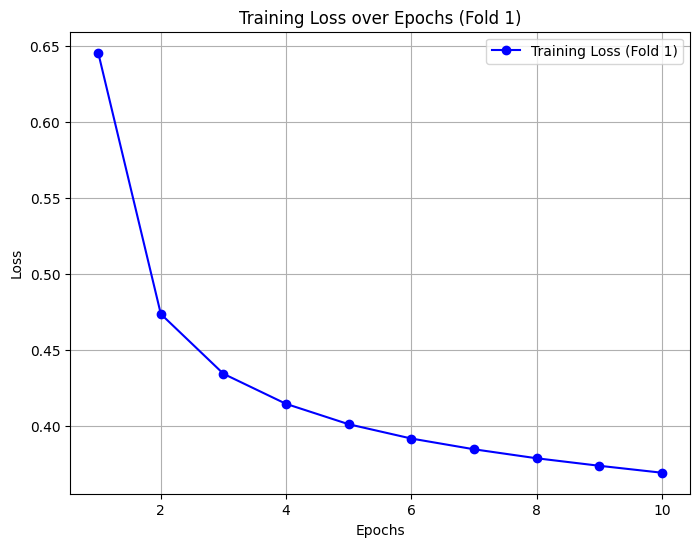

In [83]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from transformers import CLIPProcessor, CLIPModel

# Initialize the CLIP Processor and Model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.cuda()

# Map labels to numeric values for multi-class classification
label_mapping = {'Normal': 0, 'pnemo': 1, 'tb': 2}

# Assuming `full_df` is the DataFrame containing all data
# Add numeric label column
full_df['label_numeric'] = full_df['label'].map(label_mapping)

# Function to process images and extract embeddings using CLIP's image encoder
def process_images_with_clip(df):
    embeddings = []
    for idx, row in df.iterrows():
        img_path = row['image_path']
        label = row['label_numeric']

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

        # Preprocess the image using the CLIP processor
        inputs = clip_processor(images=image, return_tensors="pt")
        inputs = {k: v.cuda() for k, v in inputs.items()}
        
        with torch.no_grad():
            # Extract image features using CLIP's image encoder
            image_features = clip_model.get_image_features(**inputs)
            
            # Convert to NumPy array and flatten
            image_embedding = image_features.cpu().numpy().flatten()
            
        embeddings.append([img_path, label, image_embedding])
    return embeddings

# Process images to get embeddings using CLIP
embeddings = process_images_with_clip(full_df)

# Extract embeddings and labels
emb = []
labels = []
for item in embeddings:
    _, label, image_embedding = item
    emb.append(image_embedding)
    labels.append(label)

# Convert embeddings and labels to NumPy arrays
embedding_array = np.array(emb)
labels_array = np.array(labels)

# Define the dataset class using resampled data
class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Long labels for CrossEntropyLoss

        return embedding, label


class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes=3):  # Three output classes for multi-class classification
        super(LinearProbe, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # Three output units

    def forward(self, x):
        return self.fc(x)

# Initialize the necessary variables for 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_number = 1
input_dim = embedding_array.shape[1]

# Initialize a list to store loss values for plotting (for only one fold)
loss_values = []
all_fold_results = []

for train_index, val_index in kf.split(embedding_array, labels_array):
    print(f"Fold {fold_number}: Train size before SMOTE: {len(train_index)}, Validation size: {len(val_index)}")

    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = embedding_array[train_index], embedding_array[val_index]
    y_train_fold, y_val_fold = labels_array[train_index], labels_array[val_index]

    # Apply SMOTE only to the training fold
    smote = SMOTE(random_state=42)
    X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold, y_train_fold)
    
    # Print the new training size after SMOTE
    print(f"Fold {fold_number}: Train size after SMOTE: {len(X_train_fold_resampled)}")

    # Create Dataset and DataLoader for this fold
    train_dataset_fold = EmbeddingsDataset(X_train_fold_resampled, y_train_fold_resampled)
    val_dataset_fold = EmbeddingsDataset(X_val_fold, y_val_fold)

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False)

    # Initialize the linear probe model
    classifier_model = LinearProbe(input_dim).cuda()

    # Initialize the loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
    optimizer = optim.Adam(classifier_model.parameters(), lr=0.001)

    # Store loss values for the first fold, but training will happen for all folds
    loss_tracking = (fold_number == 1)

    # Training loop for this fold
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        classifier_model.train()
        running_loss = 0.0
        for embeddings, labels in train_loader_fold:
            embeddings, labels = embeddings.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = classifier_model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader_fold)
        if loss_tracking:  # Track loss for fold 1 only
            loss_values.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Fold {fold_number}, Loss: {avg_loss:.4f}")

    # Reset collected probabilities and labels for the current fold
    all_probabilities, all_labels = [], []

    # Evaluation for this fold
    classifier_model.eval()
    with torch.no_grad():
        for embeddings, labels in val_loader_fold:
            embeddings = embeddings.cuda()
            outputs = classifier_model(embeddings)
            probabilities = F.softmax(outputs, dim=1).cpu().numpy()  # Get probabilities for all classes

            all_probabilities.extend(probabilities)
            all_labels.extend(labels.numpy())

    # Evaluate at different thresholds for multi-class classification
    fold_results = []
    for threshold in [0.4, 0.5, 0.65]:
        all_predictions = []
        for probs in all_probabilities:
            max_prob = np.max(probs)
            if max_prob >= threshold:
                all_predictions.append(np.argmax(probs))
            else:
                # If no class exceeds the threshold, mark as "uncertain" (-1)
                all_predictions.append(-1)

        # Filter out "uncertain" predictions from the metrics
        valid_predictions = [p for p in all_predictions if p != -1]
        valid_labels = [l for i, l in enumerate(all_labels) if all_predictions[i] != -1]

        if len(valid_predictions) > 0:
            accuracy = accuracy_score(valid_labels, valid_predictions)
            precision = precision_score(valid_labels, valid_predictions, average='macro', zero_division=0)
            recall = recall_score(valid_labels, valid_predictions, average='macro', zero_division=0)
            f1 = f1_score(valid_labels, valid_predictions, average='macro', zero_division=0)

            cm = confusion_matrix(valid_labels, valid_predictions)
        else:
            accuracy = precision = recall = f1 = 0
            cm = np.zeros((3, 3))

        fold_results.append({
            'Fold': fold_number,
            'Threshold': threshold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': cm
        })

        print(f"\nFold {fold_number} - Threshold = {threshold}:")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print(f"Confusion Matrix:\n{cm}")

    # Store the fold results for each threshold
    all_fold_results.extend(fold_results)
    fold_number += 1

# Convert all fold results to a DataFrame and display
all_results_df = pd.DataFrame(all_fold_results)
print("\nAll Fold Results:")
print(all_results_df.to_string(index=False))

# Plot the loss values after training (for the first fold only)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', color='b', label='Training Loss (Fold 1)')
plt.title('Training Loss over Epochs (Fold 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [84]:
# Remove the 'Fold' column before calculating the averages
average_metrics = all_results_df.drop(columns=['Fold']).groupby('Threshold').mean().reset_index()

# Display the average metrics table
print("BioVil: Average metrics across five folds for each threshold:")
print(average_metrics.to_string(index=False))


BioVil: Average metrics across five folds for each threshold:
 Threshold  Accuracy  Precision   Recall  F1 Score                                                Confusion Matrix
      0.40  0.788980   0.779563 0.840369  0.803899 [[1546.0, 420.6, 72.0], [226.0, 919.6, 7.2], [9.0, 1.4, 287.0]]
      0.50  0.793427   0.786318 0.846459  0.810337 [[1520.6, 411.6, 67.0], [215.4, 911.8, 5.8], [6.6, 1.0, 284.8]]
      0.65  0.843837   0.836685 0.885799  0.856790 [[1256.2, 252.4, 48.4], [118.4, 762.0, 2.2], [2.6, 0.8, 276.6]]


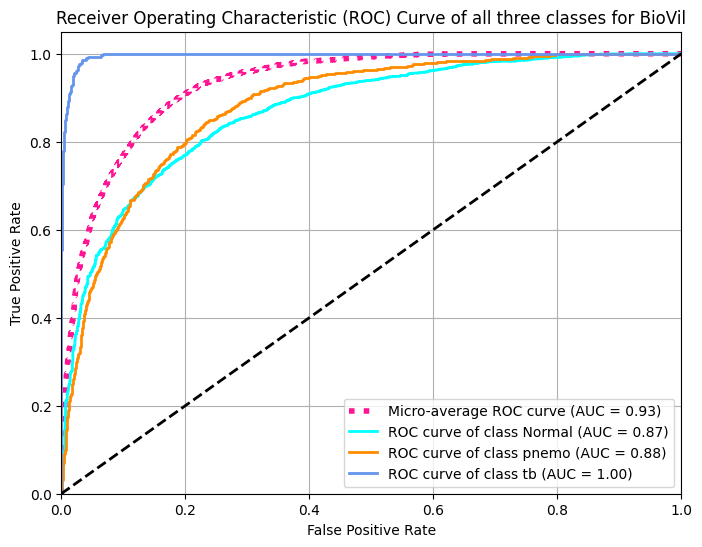

In [85]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_C = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_C = np.array(all_labels)                # Shape: (N_samples,)

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = 3
all_labels_binarized = label_binarize(all_labels_all_folds_C, classes=[0, 1, 2])  # Shape: (N_samples, n_classes)

# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probabilities_all_folds_C[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_C.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
lw = 2

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue']
class_names = ['Normal', 'pnemo', 'tb']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=lw)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of all three classes for BioVil')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Micro-average Area Under the Curve (AUC): 0.9313


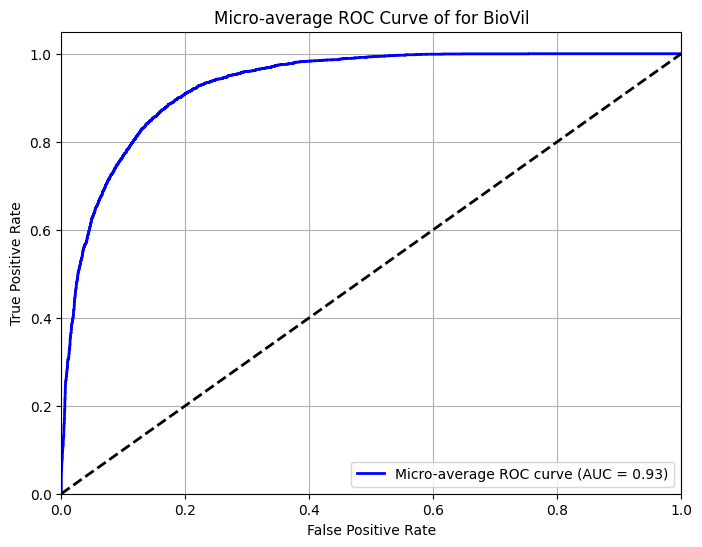

In [86]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_C = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_C = np.array(all_labels)                # Shape: (N_samples,)

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = all_probabilities_all_folds_C.shape[1]
all_labels_binarized = label_binarize(all_labels_all_folds_C, classes=[0, 1, 2])  # Adjust classes as needed

# Compute micro-average ROC curve and ROC area
from sklearn.metrics import roc_curve, auc

# Flatten the arrays for micro-average computation
fpr_micro, tpr_micro, _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_C.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Print the AUC for the micro-average ROC curve
print(f"Micro-average Area Under the Curve (AUC): {roc_auc_micro:.4f}")

# Plot the micro-average ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(fpr_micro, tpr_micro,
         label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})',
         color='blue', linewidth=2)

# Plot the diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve of for BioVil')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## BioVIL

In [119]:
!git clone https://github.com/microsoft/hi-ml.git

fatal: destination path 'hi-ml' already exists and is not an empty directory.


In [120]:
ls

'Balanced Dataset'/
 biomedclip/
 checkpoint_epoch_25.pth
 checkpoint_epoch_30.pth
 checkpoint_epoch_35.pth
 checkpoint_epoch_40.pth
 checkpoint_epoch_45.pth
 checkpoint_epoch_50.pth
 checkpoint_epoch_55.pth
 checkpoint_epoch_60.pth
 checkpoints/
 CheXpert_dataset/
 contrastive_similarity_matrix.npy
 convirt_model_weights.pth
 df_with_captions.pkl
 envenv/
 hi-ml/
'Hyperparameter tuning results towards the FSM.ipynb'
 log_hyper_towardsFSM/
 myenv/
 pnemoniaTBlp.ipynb
 predicted_similarity_matrix.pt
'Preprocessing and Model Building .ipynb'
 pretrained/
 requirements.txt
'Some preprocessing.ipynb'
 Untitled1.ipynb
 Untitled.ipynb


In [121]:
import sys
sys.path.append('/hi-ml/hi-ml-multimodal/src')

Fold 1: Train size before SMOTE: 13976, Validation size: 3494
Fold 1: Train size after SMOTE: 24492
Epoch 1/10, Fold 1, Loss: 0.8890
Epoch 2/10, Fold 1, Loss: 0.7704
Epoch 3/10, Fold 1, Loss: 0.7429
Epoch 4/10, Fold 1, Loss: 0.7032
Epoch 5/10, Fold 1, Loss: 0.6867
Epoch 6/10, Fold 1, Loss: 0.6788
Epoch 7/10, Fold 1, Loss: 0.6633
Epoch 8/10, Fold 1, Loss: 0.6537
Epoch 9/10, Fold 1, Loss: 0.6446
Epoch 10/10, Fold 1, Loss: 0.6402

Fold 1:
Accuracy: 0.6889, Precision: 0.6309, Recall: 0.7425, F1 Score: 0.6591
Confusion Matrix:
[[1394  388  260]
 [ 330  746   79]
 [  26    4  267]]
Fold 2: Train size before SMOTE: 13976, Validation size: 3494
Fold 2: Train size after SMOTE: 24495
Epoch 1/10, Fold 2, Loss: 0.8869
Epoch 2/10, Fold 2, Loss: 0.7747
Epoch 3/10, Fold 2, Loss: 0.7294
Epoch 4/10, Fold 2, Loss: 0.7040
Epoch 5/10, Fold 2, Loss: 0.6847
Epoch 6/10, Fold 2, Loss: 0.6784
Epoch 7/10, Fold 2, Loss: 0.6667
Epoch 8/10, Fold 2, Loss: 0.6479
Epoch 9/10, Fold 2, Loss: 0.6507
Epoch 10/10, Fold 2,

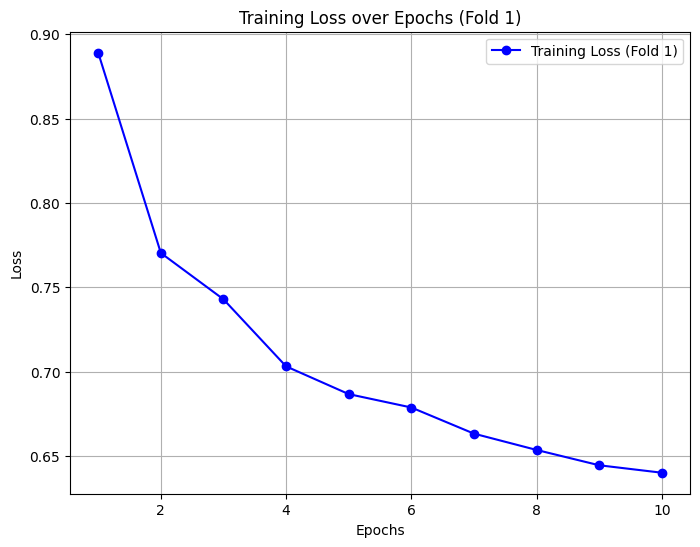

In [122]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from health_multimodal.image.model.model import ImageModel  # Import the BioViL ImageModel
import torchvision.transforms as transforms

# Initialize the BioViL image encoder with ResNet50 as the encoder type
img_encoder_type = "resnet50_multi_image"  # Change to "vit" or appropriate string for ViT in the ImageModel
joint_feature_size = 512  # Adjust this based on the model's requirements

# Instantiate the ImageModel with ResNet50 (or ViT if needed)
image_encoder = ImageModel(img_encoder_type=img_encoder_type, joint_feature_size=joint_feature_size)
image_encoder.cuda()
image_encoder.eval()  # Set to evaluation mode if you do not plan to fine-tune it

# Define image preprocessing pipeline for BioViL
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 as expected by the model
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Map labels to numeric values for multi-class classification
label_mapping = {'Normal': 0, 'pnemo': 1, 'tb': 2}

# Assuming `full_df` is the DataFrame containing all data
# Add numeric label column
full_df['label_numeric'] = full_df['label'].map(label_mapping)

# Function to process images and extract embeddings using BioViL's image encoder
def process_images_with_biovil_image_encoder(df):
    embeddings = []
    for idx, row in df.iterrows():
        img_path = row['image_path']
        label = row['label_numeric']

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

        # Apply transformation
        image_tensor = preprocess_transform(image).unsqueeze(0).cuda()  # Add a batch dimension and move to GPU
        
        with torch.no_grad():
            # Extract features using BioViL image encoder
            image_features = image_encoder(image_tensor)
            
            # Extract the global projected embedding
            image_embedding = image_features.projected_global_embedding.cpu().numpy().flatten()
            
        embeddings.append([img_path, label, image_embedding])
    return embeddings

# Process images to get embeddings using BioViL
embeddings = process_images_with_biovil_image_encoder(full_df)


# Extract embeddings and labels
emb = []
labels = []
for item in embeddings:
    _, label, image_embedding = item
    emb.append(image_embedding)
    labels.append(label)

# Convert embeddings and labels to NumPy arrays
embedding_array = np.array(emb)
labels_array = np.array(labels)

# Define the dataset class using resampled data
class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Long labels for CrossEntropyLoss

        return embedding, label


class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes=3):  # Three output classes for multi-class classification
        super(LinearProbe, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # Three output units

    def forward(self, x):
        return self.fc(x)

# Initialize the necessary variables for 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_number = 1
input_dim = embedding_array.shape[1]

# Initialize a list to store loss values for plotting (for only one fold)
loss_values = []
all_fold_results = []

for train_index, val_index in kf.split(embedding_array, labels_array):
    print(f"Fold {fold_number}: Train size before SMOTE: {len(train_index)}, Validation size: {len(val_index)}")

    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = embedding_array[train_index], embedding_array[val_index]
    y_train_fold, y_val_fold = labels_array[train_index], labels_array[val_index]

    # Apply SMOTE only to the training fold
    smote = SMOTE(random_state=42)
    X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold, y_train_fold)
    
    # Print the new training size after SMOTE
    print(f"Fold {fold_number}: Train size after SMOTE: {len(X_train_fold_resampled)}")

    # Create Dataset and DataLoader for this fold
    train_dataset_fold = EmbeddingsDataset(X_train_fold_resampled, y_train_fold_resampled)
    val_dataset_fold = EmbeddingsDataset(X_val_fold, y_val_fold)

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False)

    # Initialize the linear probe model
    classifier_model = LinearProbe(input_dim).cuda()

    # Initialize the loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
    optimizer = optim.Adam(classifier_model.parameters(), lr=0.0025)

    # Store loss values for the first fold, but training will happen for all folds
    loss_tracking = (fold_number == 1)

    # Training loop for this fold
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        classifier_model.train()
        running_loss = 0.0
        for embeddings, labels in train_loader_fold:
            embeddings, labels = embeddings.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = classifier_model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader_fold)
        if loss_tracking:  # Track loss for fold 1 only
            loss_values.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Fold {fold_number}, Loss: {avg_loss:.4f}")

    # Reset collected probabilities and labels for the current fold
    all_probabilities, all_labels = [], []

    # Evaluation for this fold
    classifier_model.eval()
    with torch.no_grad():
        for embeddings, labels in val_loader_fold:
            embeddings = embeddings.cuda()
            outputs = classifier_model(embeddings)
            probabilities = F.softmax(outputs, dim=1).cpu().numpy()  # Get probabilities for all classes

            all_probabilities.extend(probabilities)
            all_labels.extend(labels.numpy())

    # Evaluate the predictions by using argmax to pick the class with the highest probability
    all_predictions = np.argmax(all_probabilities, axis=1)

    # Calculate evaluation metrics using macro-averaging
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_predictions)

    fold_results = {
        'Fold': fold_number,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': cm
    }

    all_fold_results.append(fold_results)

    print(f"\nFold {fold_number}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    fold_number += 1

# Convert all fold results to a DataFrame and display
all_results_df = pd.DataFrame(all_fold_results)
print("\nAll Fold Results:")
print(all_results_df.to_string(index=False))

# Plot the loss values after training (for the first fold only)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', color='b', label='Training Loss (Fold 1)')
plt.title('Training Loss over Epochs (Fold 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [123]:
# Remove the 'Fold' column and the 'Confusion Matrix' column before calculating the averages
average_metrics = all_results_df.drop(columns=['Fold', 'Confusion Matrix']).mean().reset_index()

# Display the average metrics table
print("CLIP: Average metrics across five folds:")
print(average_metrics.to_string(index=False))


CLIP: Average metrics across five folds:
    index        0
 Accuracy 0.639096
Precision 0.631596
   Recall 0.716642
 F1 Score 0.625487


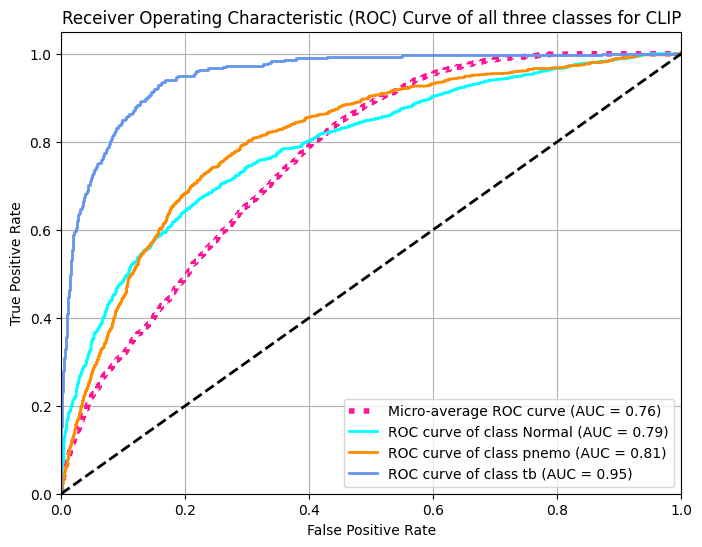

In [124]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_D = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_D = np.array(all_labels)                # Shape: (N_samples,)

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = 3
all_labels_binarized = label_binarize(all_labels_all_folds_D, classes=[0, 1, 2])  # Shape: (N_samples, n_classes)

# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probabilities_all_folds_D[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_D.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
lw = 2

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue']
class_names = ['Normal', 'pnemo', 'tb']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=lw)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of all three classes for CLIP')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Micro-average Area Under the Curve (AUC): 0.7641


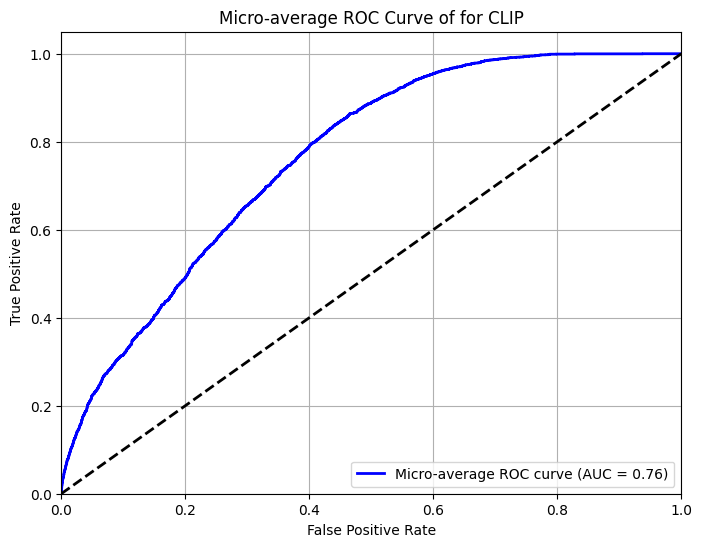

In [125]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_D = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_D = np.array(all_labels)                # Shape: (N_samples,)

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = all_probabilities_all_folds_D.shape[1]
all_labels_binarized = label_binarize(all_labels_all_folds_D, classes=[0, 1, 2])  # Adjust classes as needed

# Compute micro-average ROC curve and ROC area
from sklearn.metrics import roc_curve, auc

# Flatten the arrays for micro-average computation
fpr_micro, tpr_micro, _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_D.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Print the AUC for the micro-average ROC curve
print(f"Micro-average Area Under the Curve (AUC): {roc_auc_micro:.4f}")

# Plot the micro-average ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(fpr_micro, tpr_micro,
         label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})',
         color='blue', linewidth=2)

# Plot the diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve of for CLIP')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### TOTAL ROC of all models

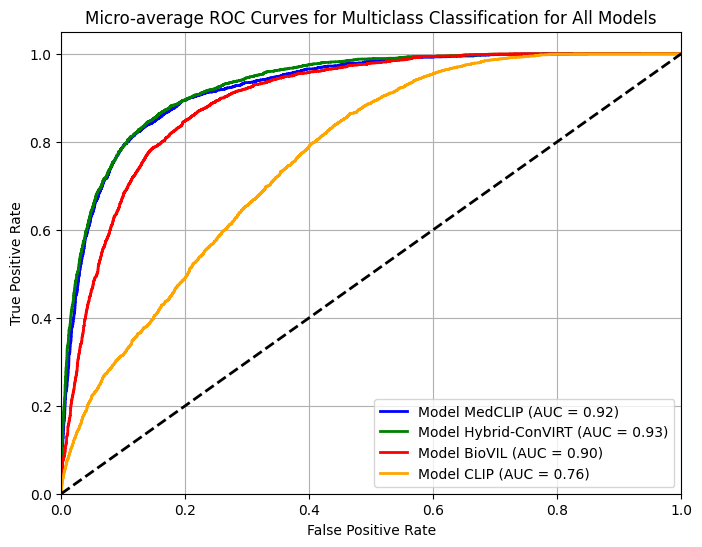

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Assuming you have the predictions and labels for all models
all_probabilities_A = np.array(all_probabilities_all_folds_A)  # Model A probabilities
all_probabilities_B = np.array(all_probabilities_all_folds_B)  # Model B probabilities
all_probabilities_C = np.array(all_probabilities_all_folds_C)  # Model C probabilities
all_probabilities_D = np.array(all_probabilities_all_folds_D)  # Model D probabilities

all_labels_A = np.array(all_labels_all_folds_A)  # Model A labels
all_labels_B = np.array(all_labels_all_folds_B)  # Model B labels
all_labels_C = np.array(all_labels_all_folds_C)  # Model C labels
all_labels_D = np.array(all_labels_all_folds_D)  # Model D labels

# Binarize the labels for multiclass ROC computation
n_classes = all_probabilities_D.shape[1]
all_labels_binarized_A = label_binarize(all_labels_A, classes=[0, 1, 2])
all_labels_binarized_B = label_binarize(all_labels_B, classes=[0, 1, 2])
all_labels_binarized_C = label_binarize(all_labels_C, classes=[0, 1, 2])
all_labels_binarized_D = label_binarize(all_labels_D, classes=[0, 1, 2])

# Function to calculate micro-average ROC and AUC
def compute_micro_roc_auc(all_labels_binarized, all_probabilities):
    fpr_micro, tpr_micro, _ = roc_curve(all_labels_binarized.ravel(), all_probabilities.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    return fpr_micro, tpr_micro, roc_auc_micro

# Compute ROC curve and AUC for each model
fpr_A, tpr_A, auc_A = compute_micro_roc_auc(all_labels_binarized_A, all_probabilities_A)
fpr_B, tpr_B, auc_B = compute_micro_roc_auc(all_labels_binarized_B, all_probabilities_B)
fpr_C, tpr_C, auc_C = compute_micro_roc_auc(all_labels_binarized_C, all_probabilities_C)
fpr_D, tpr_D, auc_D = compute_micro_roc_auc(all_labels_binarized_D, all_probabilities_D)

# Plot ROC curves for all models
plt.figure(figsize=(8, 6))

# Plotting each model's ROC curve
plt.plot(fpr_A, tpr_A, label=f'Model MedCLIP (AUC = {auc_A:.2f})', color='blue', linewidth=2)
plt.plot(fpr_B, tpr_B, label=f'Model Hybrid-ConVIRT (AUC = {auc_B:.2f})', color='green', linewidth=2)
plt.plot(fpr_C, tpr_C, label=f'Model BioVIL (AUC = {auc_C:.2f})', color='red', linewidth=2)
plt.plot(fpr_D, tpr_D, label=f'Model CLIP (AUC = {auc_D:.2f})', color='orange', linewidth=2)

# Plot the diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curves for Multiclass Classification for All Models')
plt.legend(loc="lower right")
plt.grid(True)

# Show the plot
plt.show()


## BooVil (CLIP) with thresholding

In [46]:
from health_multimodal.image.model.model import ImageModel  # Import the BioViL ImageModel

Fold 1: Train size before SMOTE: 13976, Validation size: 3494
Fold 1: Train size after SMOTE: 24492
Epoch 1/10, Fold 1, Loss: 0.9494
Epoch 2/10, Fold 1, Loss: 0.8055
Epoch 3/10, Fold 1, Loss: 0.7438
Epoch 4/10, Fold 1, Loss: 0.7180
Epoch 5/10, Fold 1, Loss: 0.7095
Epoch 6/10, Fold 1, Loss: 0.6891
Epoch 7/10, Fold 1, Loss: 0.6824
Epoch 8/10, Fold 1, Loss: 0.6761
Epoch 9/10, Fold 1, Loss: 0.6630
Epoch 10/10, Fold 1, Loss: 0.6715

Fold 1 - Threshold = 0.4:
Accuracy: 0.5912, Precision: 0.6140, Recall: 0.7243, F1 Score: 0.5789
Confusion Matrix:
[[ 734  897  352]
 [  55 1018   65]
 [   3   24  267]]

Fold 1 - Threshold = 0.5:
Accuracy: 0.6135, Precision: 0.6443, Recall: 0.7413, F1 Score: 0.6047
Confusion Matrix:
[[607 779 280]
 [ 36 979  52]
 [  2  14 260]]

Fold 1 - Threshold = 0.65:
Accuracy: 0.6521, Precision: 0.7144, Recall: 0.7345, F1 Score: 0.6205
Confusion Matrix:
[[231 464 177]
 [  2 819  36]
 [  1   3 230]]
Fold 2: Train size before SMOTE: 13976, Validation size: 3494
Fold 2: Train 

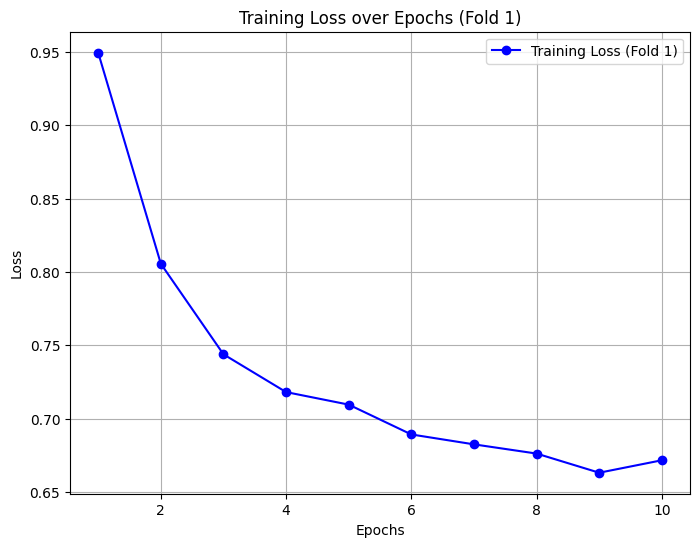

In [47]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from health_multimodal.image.model.model import ImageModel  # Import the BioViL ImageModel
import torchvision.transforms as transforms

# Initialize the BioViL image encoder with ResNet50 as the encoder type
img_encoder_type = "resnet50_multi_image"  # Change to "vit" or appropriate string for ViT in the ImageModel
joint_feature_size = 512  # Adjust this based on the model's requirements

# Instantiate the ImageModel with ResNet50 (or ViT if needed)
image_encoder = ImageModel(img_encoder_type=img_encoder_type, joint_feature_size=joint_feature_size)
image_encoder.cuda()
image_encoder.eval()  # Set to evaluation mode if you do not plan to fine-tune it

# Define image preprocessing pipeline for BioViL
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 as expected by the model
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Map labels to numeric values for multi-class classification
label_mapping = {'Normal': 0, 'pnemo': 1, 'tb': 2}

# Assuming `full_df` is the DataFrame containing all data
# Add numeric label column
full_df['label_numeric'] = full_df['label'].map(label_mapping)

# Function to process images and extract embeddings using BioViL's image encoder
def process_images_with_biovil_image_encoder(df):
    embeddings = []
    for idx, row in df.iterrows():
        img_path = row['image_path']
        label = row['label_numeric']

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

        # Apply transformation
        image_tensor = preprocess_transform(image).unsqueeze(0).cuda()  # Add a batch dimension and move to GPU
        
        with torch.no_grad():
            # Extract features using BioViL image encoder
            image_features = image_encoder(image_tensor)
            
            # Extract the global projected embedding
            image_embedding = image_features.projected_global_embedding.cpu().numpy().flatten()
            
        embeddings.append([img_path, label, image_embedding])
    return embeddings

# Process images to get embeddings using BioViL
embeddings = process_images_with_biovil_image_encoder(full_df)


# Extract embeddings and labels
emb = []
labels = []
for item in embeddings:
    _, label, image_embedding = item
    emb.append(image_embedding)
    labels.append(label)

# Convert embeddings and labels to NumPy arrays
embedding_array = np.array(emb)
labels_array = np.array(labels)

# Define the dataset class using resampled data
class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Long labels for CrossEntropyLoss

        return embedding, label


class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes=3):  # Three output classes for multi-class classification
        super(LinearProbe, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # Three output units

    def forward(self, x):
        return self.fc(x)

# Initialize the necessary variables for 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_number = 1
input_dim = embedding_array.shape[1]

# Initialize a list to store loss values for plotting (for only one fold)
loss_values = []
all_fold_results = []

for train_index, val_index in kf.split(embedding_array, labels_array):
    print(f"Fold {fold_number}: Train size before SMOTE: {len(train_index)}, Validation size: {len(val_index)}")

    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = embedding_array[train_index], embedding_array[val_index]
    y_train_fold, y_val_fold = labels_array[train_index], labels_array[val_index]

    # Apply SMOTE only to the training fold
    smote = SMOTE(random_state=42)
    X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold, y_train_fold)
    
    # Print the new training size after SMOTE
    print(f"Fold {fold_number}: Train size after SMOTE: {len(X_train_fold_resampled)}")

    # Create Dataset and DataLoader for this fold
    train_dataset_fold = EmbeddingsDataset(X_train_fold_resampled, y_train_fold_resampled)
    val_dataset_fold = EmbeddingsDataset(X_val_fold, y_val_fold)

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False)

    # Initialize the linear probe model
    classifier_model = LinearProbe(input_dim).cuda()

    # Initialize the loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
    optimizer = optim.Adam(classifier_model.parameters(), lr=0.0025)

    # Store loss values for the first fold, but training will happen for all folds
    loss_tracking = (fold_number == 1)

    # Training loop for this fold
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        classifier_model.train()
        running_loss = 0.0
        for embeddings, labels in train_loader_fold:
            embeddings, labels = embeddings.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = classifier_model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader_fold)
        if loss_tracking:  # Track loss for fold 1 only
            loss_values.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Fold {fold_number}, Loss: {avg_loss:.4f}")

    # Reset collected probabilities and labels for the current fold
    all_probabilities, all_labels = [], []

    # Evaluation for this fold
    classifier_model.eval()
    with torch.no_grad():
        for embeddings, labels in val_loader_fold:
            embeddings = embeddings.cuda()
            outputs = classifier_model(embeddings)
            probabilities = F.softmax(outputs, dim=1).cpu().numpy()  # Get probabilities for all classes

            all_probabilities.extend(probabilities)
            all_labels.extend(labels.numpy())

    # Evaluate at different thresholds for multi-class classification
    fold_results = []
    for threshold in [0.4, 0.5, 0.65]:
        all_predictions = []
        for probs in all_probabilities:
            max_prob = np.max(probs)
            if max_prob >= threshold:
                all_predictions.append(np.argmax(probs))
            else:
                # If no class exceeds the threshold, mark as "uncertain" (-1)
                all_predictions.append(-1)

        # Filter out "uncertain" predictions from the metrics
        valid_predictions = [p for p in all_predictions if p != -1]
        valid_labels = [l for i, l in enumerate(all_labels) if all_predictions[i] != -1]

        if len(valid_predictions) > 0:
            accuracy = accuracy_score(valid_labels, valid_predictions)
            precision = precision_score(valid_labels, valid_predictions, average='macro', zero_division=0)
            recall = recall_score(valid_labels, valid_predictions, average='macro', zero_division=0)
            f1 = f1_score(valid_labels, valid_predictions, average='macro', zero_division=0)

            cm = confusion_matrix(valid_labels, valid_predictions)
        else:
            accuracy = precision = recall = f1 = 0
            cm = np.zeros((3, 3))

        fold_results.append({
            'Fold': fold_number,
            'Threshold': threshold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': cm
        })

        print(f"\nFold {fold_number} - Threshold = {threshold}:")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print(f"Confusion Matrix:\n{cm}")

    # Store the fold results for each threshold
    all_fold_results.extend(fold_results)
    fold_number += 1

# Convert all fold results to a DataFrame and display
all_results_df = pd.DataFrame(all_fold_results)
print("\nAll Fold Results:")
print(all_results_df.to_string(index=False))

# Plot the loss values after training (for the first fold only)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', color='b', label='Training Loss (Fold 1)')
plt.title('Training Loss over Epochs (Fold 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [48]:
# Remove the 'Fold' column before calculating the averages
average_metrics = all_results_df.drop(columns=['Fold']).groupby('Threshold').mean().reset_index()

# Display the average metrics table
print("CLIP: Average metrics across five folds for each threshold:")
print(average_metrics.to_string(index=False))


CLIP: Average metrics across five folds for each threshold:
 Threshold  Accuracy  Precision   Recall  F1 Score                                                    Confusion Matrix
      0.40  0.629831   0.617972 0.709453  0.606839 [[1032.2, 649.8, 319.6], [182.6, 886.6, 69.6], [30.6, 17.2, 245.0]]
      0.50  0.654650   0.650353 0.737620  0.636830   [[915.2, 563.2, 256.0], [145.4, 845.6, 50.0], [20.4, 8.8, 235.2]]
      0.65  0.707754   0.722409 0.769954  0.686369     [[546.8, 322.0, 155.0], [57.6, 653.2, 26.0], [9.2, 2.2, 199.6]]


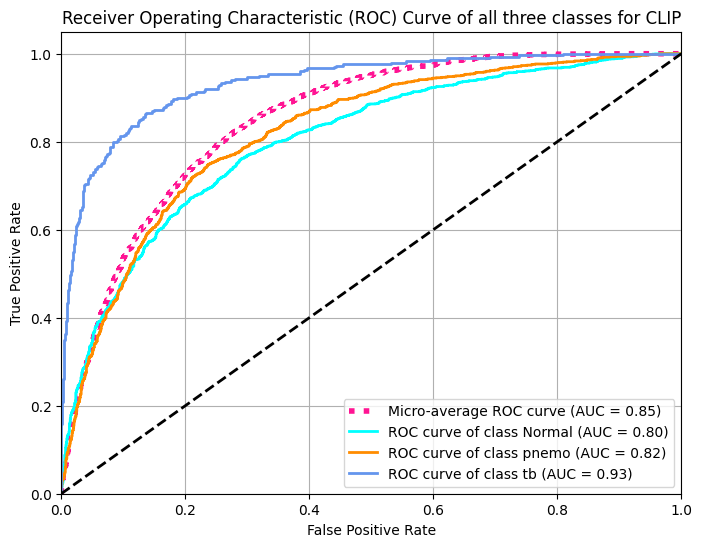

In [49]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_D = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_D = np.array(all_labels)                # Shape: (N_samples,)

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = 3
all_labels_binarized = label_binarize(all_labels_all_folds_D, classes=[0, 1, 2])  # Shape: (N_samples, n_classes)

# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probabilities_all_folds_D[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_D.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
lw = 2

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue']
class_names = ['Normal', 'pnemo', 'tb']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=lw)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of all three classes for CLIP')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Micro-average Area Under the Curve (AUC): 0.8500


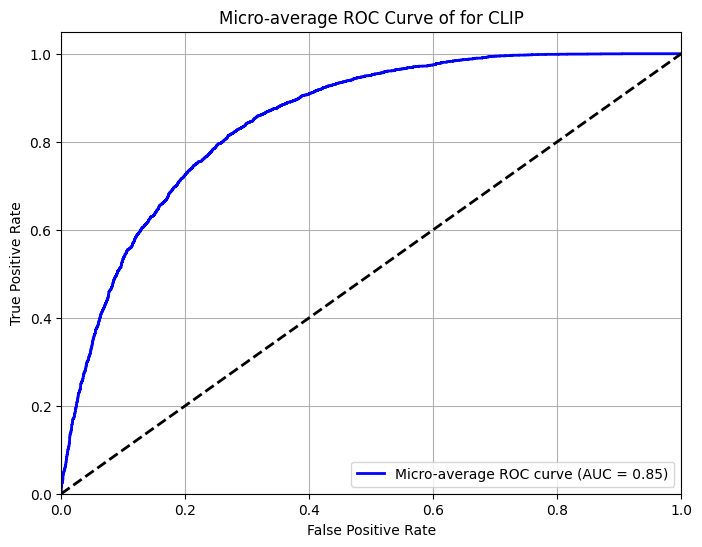

In [50]:
# After the cross-validation loop
# Convert lists to numpy arrays
all_probabilities_all_folds_D = np.array(all_probabilities)  # Shape: (N_samples, n_classes)
all_labels_all_folds_D = np.array(all_labels)                # Shape: (N_samples,)

# Binarize the labels for multiclass ROC computation
from sklearn.preprocessing import label_binarize
n_classes = all_probabilities_all_folds_D.shape[1]
all_labels_binarized = label_binarize(all_labels_all_folds_D, classes=[0, 1, 2])  # Adjust classes as needed

# Compute micro-average ROC curve and ROC area
from sklearn.metrics import roc_curve, auc

# Flatten the arrays for micro-average computation
fpr_micro, tpr_micro, _ = roc_curve(all_labels_binarized.ravel(), all_probabilities_all_folds_D.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Print the AUC for the micro-average ROC curve
print(f"Micro-average Area Under the Curve (AUC): {roc_auc_micro:.4f}")

# Plot the micro-average ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(fpr_micro, tpr_micro,
         label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})',
         color='blue', linewidth=2)

# Plot the diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve of for CLIP')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


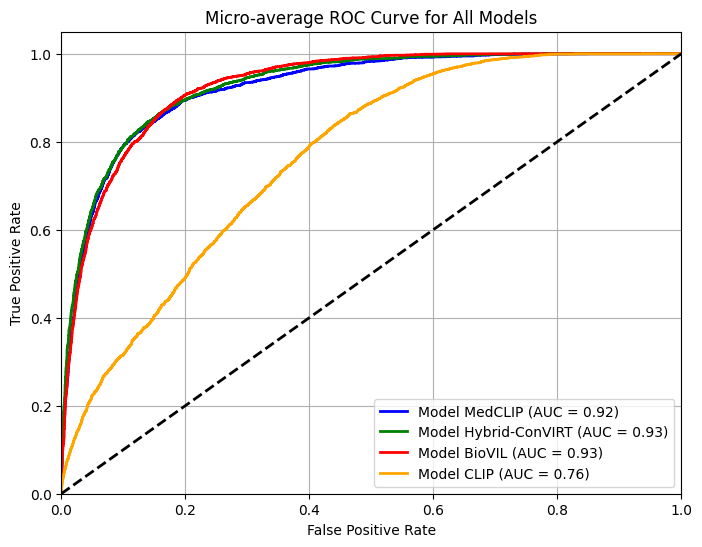

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Assuming you have the predictions and labels for all models
all_probabilities_A = np.array(all_probabilities_all_folds_A)  # Model A probabilities
all_probabilities_B = np.array(all_probabilities_all_folds_B)  # Model B probabilities
all_probabilities_C = np.array(all_probabilities_all_folds_C)  # Model C probabilities
all_probabilities_D = np.array(all_probabilities_all_folds_D)  # Model D probabilities

all_labels_A = np.array(all_labels_all_folds_A)  # Model A labels
all_labels_B = np.array(all_labels_all_folds_B)  # Model B labels
all_labels_C = np.array(all_labels_all_folds_C)  # Model C labels
all_labels_D = np.array(all_labels_all_folds_D)  # Model D labels

# Binarize the labels for multiclass ROC computation
n_classes = all_probabilities_D.shape[1]
all_labels_binarized_A = label_binarize(all_labels_A, classes=[0, 1, 2])
all_labels_binarized_B = label_binarize(all_labels_B, classes=[0, 1, 2])
all_labels_binarized_C = label_binarize(all_labels_C, classes=[0, 1, 2])
all_labels_binarized_D = label_binarize(all_labels_D, classes=[0, 1, 2])

# Function to calculate micro-average ROC and AUC
def compute_micro_roc_auc(all_labels_binarized, all_probabilities):
    fpr_micro, tpr_micro, _ = roc_curve(all_labels_binarized.ravel(), all_probabilities.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    return fpr_micro, tpr_micro, roc_auc_micro

# Compute ROC curve and AUC for each model
fpr_A, tpr_A, auc_A = compute_micro_roc_auc(all_labels_binarized_A, all_probabilities_A)
fpr_B, tpr_B, auc_B = compute_micro_roc_auc(all_labels_binarized_B, all_probabilities_B)
fpr_C, tpr_C, auc_C = compute_micro_roc_auc(all_labels_binarized_C, all_probabilities_C)
fpr_D, tpr_D, auc_D = compute_micro_roc_auc(all_labels_binarized_D, all_probabilities_D)

# Plot ROC curves for all models
plt.figure(figsize=(8, 6))

# Plotting each model's ROC curve
plt.plot(fpr_A, tpr_A, label=f'Model MedCLIP (AUC = {auc_A:.2f})', color='blue', linewidth=2)
plt.plot(fpr_B, tpr_B, label=f'Model Hybrid-ConVIRT (AUC = {auc_B:.2f})', color='green', linewidth=2)
plt.plot(fpr_C, tpr_C, label=f'Model BioVIL (AUC = {auc_C:.2f})', color='red', linewidth=2)
plt.plot(fpr_D, tpr_D, label=f'Model CLIP (AUC = {auc_D:.2f})', color='orange', linewidth=2)

# Plot the diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve for All Models')
plt.legend(loc="lower right")
plt.grid(True)

# Show the plot
plt.show()
